**Name: Nidhi Rajkumar Saini<br>
USC ID: 3730422872**

## Import required libraries

In [58]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
import nltk
import re
from bs4 import BeautifulSoup

import contractions
from nltk.corpus import stopwords
nltk.download('stopwords', quiet = True)
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.linear_model import Perceptron
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

import tensorflow as tf
import random

random.seed(42)

import warnings
warnings.filterwarnings('ignore')

In [3]:
#! pip install bs4 # in case you don't have it installed

# Dataset: https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Kitchen_v1_00.tsv.gz

# Dataset Generation

- Used pandas read_csv method to read the Amazon reviews dataset .gz file into a pandas dataframe. The compression parameter for this method is set to infer by default, which can automatically infer the kind of files i.e gzip , zip , bz2 , xz from the file extension.
- error_bad_lines is used to drop lines with too many fields (e.g. a csv line with too many commas).
- warn_bad_lines is used to supress the logs showing skipped lines.
- pandas.DataFrame.head method returns the first n rows of the dataframe.

In [59]:
df = pd.read_csv('https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Kitchen_v1_00.tsv.gz', sep="\t", error_bad_lines = False, warn_bad_lines = False)
df.head(3)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,37000337,R3DT59XH7HXR9K,B00303FI0G,529320574,Arthur Court Paper Towel Holder,Kitchen,5.0,0.0,0.0,N,Y,Beautiful. Looks great on counter,Beautiful. Looks great on counter.,2015-08-31
1,US,15272914,R1LFS11BNASSU8,B00JCZKZN6,274237558,Olde Thompson Bavaria Glass Salt and Pepper Mi...,Kitchen,5.0,0.0,1.0,N,Y,Awesome & Self-ness,I personally have 5 days sets and have also bo...,2015-08-31
2,US,36137863,R296RT05AG0AF6,B00JLIKA5C,544675303,Progressive International PL8 Professional Man...,Kitchen,5.0,0.0,0.0,N,Y,Fabulous and worth every penny,Fabulous and worth every penny. Used for clean...,2015-08-31


- Selected only the required Reviews and Ratings fields from the input dataframe and renamed them as 'reviews' and 'ratings' respectively.
- Used pandas.DataFrame.sample method to return a random sample of n rows of the dataframe.

In [60]:
selected_df = df[['star_rating', 'review_body']].rename(columns={'star_rating': 'ratings', 'review_body':'reviews'})
selected_df.sample(n = 3)

,ratings,reviews
1262296,1.0,Don't do it! there are other options that don'...
3383550,5.0,This bag is so spacious that I easily fits all...
4715509,2.0,"It makes a big mess in the kitchen, spitting w..."


- Calculated statistics of ratings by taking an aggregated count after grouping the dataframe by column 'ratings'.
- Plotted a bar chart to visualize the results.

         reviews
ratings         
1.0       426870
2.0       241939
3.0       349539
4.0       731701
5.0      3124595


<AxesSubplot:xlabel='ratings'>

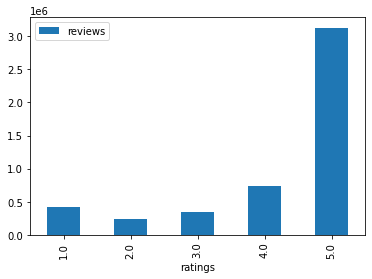

In [61]:
# Reporting the statistics of the ratings, i.e., how many reviews received 1 ratings, etc.
stats_df = selected_df.groupby(selected_df['ratings']).agg('count')
print(stats_df)
stats_df.plot.bar(y='reviews')

## Build a balanced dataset

- Used sklearn.utils.resample method to keep only 50K instances of each ratings from 1-5.

In [62]:
# Build a balanced dataset of 250K reviews along with their ratings (50K instances per each rating score) through random selection.
balanced_df = []
for i in range(1,6):
    updated_df = resample(selected_df[selected_df['ratings'] == i], 
                          replace = True, 
                          n_samples = 50000, 
                          random_state = 42)
    balanced_df.append(updated_df)
resampled_df = pd.concat(balanced_df, ignore_index = True)
resampled_df

,ratings,reviews
0,1.0,I had this for about a year and it stopped wor...
1,1.0,Cant give it any stars.... just got mine yeste...
2,1.0,I just got this cup in the mail for my dad's 5...
3,1.0,I got this as a wedding gift. We used it once ...
4,1.0,We purchased this item less than two months ag...
...,...,...
249995,5.0,Awesome aerator. It works fabulously. The pr...
249996,5.0,"Excellent, versatile strainer. Sits on top of ..."
249997,5.0,fits
249998,5.0,"I usually use Ceramic kitchen knives, but this..."


- Used pandas.DataFrame.value_counts() to verify the count of reviews for each rating.

In [63]:
resampled_df.ratings.value_counts()

1.0    50000
2.0    50000
3.0    50000
4.0    50000
5.0    50000
Name: ratings, dtype: int64

## Labelling Reviews:
Create ternary labels using the ratings.

- Created function label_review to return labels according to the ratings as asked by the problem statement.
- Ratings 1 & 2 = Label 0, Ratings 4 & 5 = Label 1, Rating 3 = Label 2
- Used pandas.DataFrame.apply method to apply label_review function to each row of the 'ratings' column and get labels.
- Used pandas.DataFrame.assign method to assign new column 'label' to the dataframe with values returned by the pandas.DataFrame.apply method.

In [64]:
def label_review(row):
    if row['ratings'] == 1 or row['ratings'] == 2:
        return 0
    elif row['ratings'] == 4 or row['ratings'] == 5:
        return 1
    else:
        return 2

In [65]:
col = resampled_df.apply(label_review, axis = 1) # get column data with an index
resampled_df = resampled_df.assign(label = col.values) # assign values to column 'label'
resampled_df

,ratings,reviews,label
0,1.0,I had this for about a year and it stopped wor...,0
1,1.0,Cant give it any stars.... just got mine yeste...,0
2,1.0,I just got this cup in the mail for my dad's 5...,0
3,1.0,I got this as a wedding gift. We used it once ...,0
4,1.0,We purchased this item less than two months ag...,0
...,...,...,...
249995,5.0,Awesome aerator. It works fabulously. The pr...,1
249996,5.0,"Excellent, versatile strainer. Sits on top of ...",1
249997,5.0,fits,1
249998,5.0,"I usually use Ceramic kitchen knives, but this...",1


- Selected only required two columns 'reviews' and 'label' from resampled_df.

In [66]:
resampled_df = resampled_df[['reviews','label']]

- Stored dataset after generation to reduce the computational load.

In [51]:
resampled_df.to_csv('resampled_review_data.csv', index = False)

In [67]:
resampled_df = pd.read_csv('resampled_review_data.csv')

## Average length of reviews (Before Cleaning)

- Calculated the average length of reviews by using the len method to get the character length of each review and then taking the mean of the same, by using the pandas.DataFrame.mean method.
- Used pandas.DataFrame.apply method to apply above function to each row of the 'reviews' column.

In [68]:
# printing the average length of the reviews in terms of character length in the dataset before cleaning
resampled_df['reviews'].apply(lambda x: len(str(x))).mean()

340.40554

## 3 sample reviews (Before Data Cleaning + Preprocessing)

- Used pandas.DataFrame.sample method to return a random sample of n rows of the dataframe.

In [69]:
# Printing three sample reviews before data cleaning + preprocessing
resampled_df.sample(n = 3)

,reviews,label
84878,CR rated this one highly so we went with it. I...,0
249903,My grandson is a type 1 diabetic and we have t...,1
137845,"I needed a larger skillet and boy, is this pan...",2


## Data Cleaning

### Convert all the reviews into lower case.

- Used str.lower() method to convert all reviews into lower case.
- Used pandas.DataFrame.apply method to apply above function to each row of the 'reviews' column.

In [70]:
resampled_df['reviews'] = resampled_df['reviews'].apply(lambda x: str(x).lower())
# Dataframe after converting to lower case
resampled_df

,reviews,label
0,i had this for about a year and it stopped wor...,0
1,cant give it any stars.... just got mine yeste...,0
2,i just got this cup in the mail for my dad's 5...,0
3,i got this as a wedding gift. we used it once ...,0
4,we purchased this item less than two months ag...,0
...,...,...
249995,awesome aerator. it works fabulously. the pr...,1
249996,"excellent, versatile strainer. sits on top of ...",1
249997,fits,1
249998,"i usually use ceramic kitchen knives, but this...",1


### Remove the HTML and URLs from the reviews.

- Used BeautifulSoup to remove the HTML tags as it is a Python package that creates a parse tree for parsed pages that can be used to extract data from HTML.
- Used regular expressions to identify and remove any URLs from the reviews.
- Used pandas.DataFrame.apply method to apply above functions to each row of the 'reviews' column.

In [71]:
def remove_html(string):
    soup = BeautifulSoup(string, "html.parser")
    return soup.get_text()

In [72]:
def remove_urls(string):
    result = re.sub(r'http\S+', '', string)
    return result

In [73]:
# removing the HTML and URLs from the reviews
resampled_df['reviews'] = resampled_df['reviews'].apply(lambda x: remove_html(str(x)))
resampled_df['reviews'] = resampled_df['reviews'].apply(lambda x: remove_urls(x))

### Remove non-alphabetical characters

- Used regular expressions to identify and remove non-alphabetical characters from the reviews(except spaces so that we can differentiate between words).
- Used pandas.DataFrame.apply method to apply above function to each row of the 'reviews' column in the dataframe.

In [9]:
def remove_nonalphachars(string):
    result = re.sub(r'[^a-zA-Z\s]','',string)
    return result

In [10]:
# Identifying rows with non-alphabetical characters in reviews
df_check = resampled_df[resampled_df.reviews.str.contains('[^a-zA-Z\s]', regex = True, na = False)]
idx_nonalpha = df_check.index.tolist()
df_check

,reviews,label
0,i had this for about a year and it stopped wor...,0
1,cant give it any stars.... just got mine yeste...,0
2,i just got this cup in the mail for my dad's 5...,0
3,i got this as a wedding gift. we used it once ...,0
4,we purchased this item less than two months ag...,0
...,...,...
249994,trays were awesome! the molds were detailed a...,1
249995,awesome aerator. it works fabulously. the pr...,1
249996,"excellent, versatile strainer. sits on top of ...",1
249998,"i usually use ceramic kitchen knives, but this...",1


In [11]:
# Saving indices of reviews having contractions to test later
df_contractions = resampled_df[resampled_df.reviews.str.contains('\'', regex = True, na = False)]
idx_contractions = df_check[:10].index.tolist()

In [12]:
# removing the non-alphabetical characters from the reviews
resampled_df['reviews'] = resampled_df['reviews'].apply(remove_nonalphachars)
resampled_df.loc[idx_nonalpha]

,reviews,label
0,i had this for about a year and it stopped wor...,0
1,cant give it any stars just got mine yesterday...,0
2,i just got this cup in the mail for my dads th...,0
3,i got this as a wedding gift we used it once i...,0
4,we purchased this item less than two months ag...,0
...,...,...
249994,trays were awesome the molds were detailed an...,1
249995,awesome aerator it works fabulously the pric...,1
249996,excellent versatile strainer sits on top of mi...,1
249998,i usually use ceramic kitchen knives but this ...,1


### Remove the extra spaces between the words

- Used regular expressions to identify and remove extra spaces between the words.
- Used pandas.DataFrame.apply method to apply above function to each row of the 'reviews' column in the dataframe.

In [13]:
def remove_extra_space(string):
    result = re.sub(r'\s+',' ',string)
    return result

In [14]:
# removing extra spaces from the reviews
resampled_df['reviews'] = resampled_df['reviews'].apply(remove_extra_space)

### Perform contractions on the reviews.

- Used contractions library to perform contractions on the reviews and then expand them by applying contractions.fix method to each word in the review sentence.
- Used pandas.DataFrame.apply method to apply above function to each row of the 'reviews' column in the dataframe.

In [15]:
def contraction_function(review):
    contraction_str = []
    for word in review.split(' '):
        contraction_str.append(contractions.fix(word))
    return ' '.join(contraction_str)

In [16]:
# Before removing contractions from the reviews
df_contractions[:10]

,reviews,label
1,cant give it any stars.... just got mine yeste...,0
2,i just got this cup in the mail for my dad's 5...,0
3,i got this as a wedding gift. we used it once ...,0
4,we purchased this item less than two months ag...,0
6,"bought from another site, and only used a hand...",0
7,first time i tried blending my bpc it spewed a...,0
10,it's bull**** it's only 0.1g not 0.01g don't buy,0
11,i tried to grind up duck. what meat did come ...,0
12,"update: after two years and maybe 4 uses, it b...",0
14,too difficult to clean the cap interior. i've...,0


In [17]:
# After removing contractions from the reviews
resampled_df['reviews'] = resampled_df['reviews'].apply(contraction_function)
resampled_df.loc[idx_contractions]

,reviews,label
0,i had this for about a year and it stopped wor...,0
1,cannot give it any stars just got mine yesterd...,0
2,i just got this cup in the mail for my dads th...,0
3,i got this as a wedding gift we used it once i...,0
4,we purchased this item less than two months ag...,0
5,arrived broken very badly made what i should h...,0
6,bought from another site and only used a handf...,0
7,first time i tried blending my bpc it spewed a...,0
8,not worth the effort if you are going to buy a...,0
9,the meat cutting shipped to me is not from xtr...,0


### Average length of reviews (After Cleaning)

- Calculated the average length of reviews by using the len method to get the character length of each review and then taking the mean of the same, by using the pandas.DataFrame.mean method.
- Used pandas.DataFrame.apply method to apply above function to each row of the 'reviews' column.

In [18]:
# print the average length of the reviews in terms of character length in your dataset after cleaning
resampled_df['reviews'].apply(lambda x: len(str(x))).mean()

324.165856


## Pre-processing

### Remove the stop words 

- Used nltk.corpus.stopwords package to remove all stop words from the reviews.
- Used nltk.tokenize.word_tokenize to tokenize the sentence into words and then checked if each word was a stop word and removed the stop words.

In [19]:
stopword = set(stopwords.words('english'))
def remove_stop_words(string):
    text_tokens = word_tokenize(string)
    tokens_without_sw = [word for word in text_tokens if not word in stopword]
    filtered_sentence = (" ").join(tokens_without_sw)
    return filtered_sentence

In [20]:
# Identifying stop words
resampled_df.head(3)

,reviews,label
0,i had this for about a year and it stopped wor...,0
1,cannot give it any stars just got mine yesterd...,0
2,i just got this cup in the mail for my dads th...,0


In [21]:
# Removing stop words from the reviews
resampled_df['reviews'] = resampled_df['reviews'].apply(remove_stop_words)
resampled_df.head(3)

,reviews,label
0,year stopped working gentle use fresh batterie...,0
1,give stars got mine yesterday go plug tried di...,0
2,got cup mail dads th birthday next month defin...,0


### 3 sample reviews (After Data Cleaning + Preprocessing)

In [22]:
# Printing three sample reviews after data cleaning + preprocessing
resampled_df.sample(n = 3)

,reviews,label
164556,saves money buy pods constantly,1
64992,stains always looks dirty fan,0
217706,easy works great easy clean love,1


## Splitting the dataset into Train and Test

- Used sklearn.model_selection.train_test_split to split the dataset into training and testing dataset. 

In [23]:
# Split your dataset into 80% training dataset and 20% testing dataset.
train_df,test_df = train_test_split(resampled_df, train_size = 0.8, random_state = 42)

# Word Embedding

## TF-IDF Feature Extraction

- Used sklearn.feature_extraction.text.TfidfVectorizer to extract TF-IDF features from the dataframe.

In [74]:
vectorizer = TfidfVectorizer()
vectorizer.fit(train_df['reviews'].tolist())

TfidfVectorizer()

## Word2Vec

In [25]:
# Importing required libraries to load word2vec models

from gensim.models import Word2Vec
from gensim import models
import gensim.downloader as api

### Load the pretrained “word2vec-google-news-300” Word2Vec model.

In [26]:
# google_model = models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True)
google_model = api.load('word2vec-google-news-300')

In [27]:
google_model

#### Check semantic similarities of the generated vectors using two examples of your own, e.g., King − Man + Woman = Queen or excellent ∼ outstanding.

- Used sklearn.metrics.pairwise.cosine_similarity metric to check semantic similarities between two vectors. Cosine similarity returns the cosine of the angle between the two vectors. Therefore, the higher the cosine similarity value, the lower the angle between the vectors and thus, the closer the vectors to each other.
- Ideally, any two semantically same vectors should have cosine similarity score of 1.

In [28]:
a = google_model['husband'] - google_model['man'] + google_model['woman']
b = google_model['wife']
cosine_similarity(a.reshape(1,-1),b.reshape(1,-1))

array([[0.73326993]], dtype=float32)

In [29]:
a = google_model['tiny']
b = google_model['small']
cosine_similarity(a.reshape(1,-1),b.reshape(1,-1))

array([[0.7187928]], dtype=float32)

### Train a Word2Vec model using your own dataset. Set the embedding size to be 300 and the window size to be 11. You can also consider a minimum word count of 10.

- I split each review into its constituent words using the split function in python.
- Then, I trained a Word2Vec model on the above defined data with a vector size of 300, window size of 11 and minimum word count of 10 as asked by the problem statement.
- Finally, after the model is trained, I save it in a .bin file for faster loading.

In [52]:
sentences = [x.split(' ') for x in resampled_df['reviews'].tolist()]

w2v_model = Word2Vec(sentences=sentences,vector_size=300,window=11,min_count=10)
w2v_model.save('data/my_w2v_model.bin')

In [30]:
w2v_model = Word2Vec.load('data/my_w2v_model.bin')

In [31]:
w2v_model

#### Check the semantic similarities for the same two examples in part (a).

- Used sklearn.metrics.pairwise.cosine_similarity metric to check semantic similarities between two vectors. Cosine similarity returns the cosine of the angle between the two vectors. Therefore, the higher the cosine similarity value, the lower the angle between the vectors and thus, the closer the vectors to each other.
- Ideally, any two semantically same vectors should have cosine similarity score of 1.

In [32]:
a = w2v_model.wv['husband'] - w2v_model.wv['man'] + w2v_model.wv['woman']
b = w2v_model.wv['wife']
cosine_similarity(a.reshape(1,-1),b.reshape(1,-1))

array([[0.7663224]], dtype=float32)

In [33]:
a = w2v_model.wv['tiny']
b = w2v_model.wv['small']
cosine_similarity(a.reshape(1,-1),b.reshape(1,-1))

array([[0.7121456]], dtype=float32)

### What do you conclude from comparing vectors generated by yourself and the pretrained model?

- Both my word2vec and the pretrained word2vec models were able to capture the semantic similarities correctly for the above examples.
- This is evident by the high cosine similarity between vectors a and b taken in the examples.
- In conclusion, the performance of the models trained using both the above embeddings should not vary by a lot.

### Which of the Word2Vec models seems to encode semantic similarities between words better?

- Although both the word2vec models have very similar cosine similarity scores on the above examples, my word2vec model (approx 76%) performs slightly better than the pretrained one (approx 73%) on the first example.

## Function to compute metrics

- Created function that uses accuracy_score, precision_score, recall_score and f1_score methods from sklearn.metrics module to get the metrics.

In [34]:
def compute_scores(text, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1score = f1_score(y_true, y_pred)
    print("{} Metrics:\nAccuracy = {}\nPrecision = {}\nRecall = {}\nF1-score = {}\n".format(text, accuracy, precision, recall, f1score))

# Simple models

## Perceptron

- Used sklearn.linear_model.Perceptron to train a Perceptron model on the training dataset.

In [80]:
def train_test_perceptron(X_train, y_train, X_test, y_test):
    model = Perceptron()
    model.fit(X_train, y_train.ravel())

    # make a prediction
    ytrain_pred = model.predict(X_train)
    ytest_pred = model.predict(X_test)

    #calculate metrics
    compute_scores("Train", y_train, ytrain_pred)
    compute_scores("Test", y_test, ytest_pred)

### TFIDF: Binary classification

- For binary classification, I selected reviews with label 0 (negative) and 1 (positive). Then concatenated the dataframes to a single dataframe using pandas.concat() method.
- Then retrieved the TFIDF vectors for each review using the TFIDF vectorizer's transform function.
- Finally, performed training and testing of the perceptron model and reported the metrics.

In [81]:
new_train_df = pd.concat([train_df[train_df['label'] == 0],train_df[train_df['label'] == 1]])

new_test_df = pd.concat([test_df[test_df['label'] == 0],test_df[test_df['label'] == 1]])

X_train = vectorizer.transform(new_train_df['reviews'].tolist())
X_test = vectorizer.transform(new_test_df['reviews'].tolist())
y_train = new_train_df['label']
y_test = new_test_df['label']
train_test_perceptron(X_train,y_train,X_test,y_test)

Train Metrics:
Accuracy = 0.907058411857332
Precision = 0.8874558977782016
Recall = 0.932003104423804
F1-score = 0.9091841594314394

Test Metrics:
Accuracy = 0.8387298568711841
Precision = 0.8229762298568121
Recall = 0.8658148553246495
F1-score = 0.8438522107813446



### Pretrained Google Word2Vec: Binary classification

- For binary classification, I selected reviews with label 0 (negative) and 1 (positive). Then concatenated the dataframes to a single dataframe using pandas.concat() method.
- Created default vector using the np.zeros() function in case a word is missing from the Google word2vec vocabulary.
- Then retrieved the vectors for each review by averaging the Google word2vec vector for each word in the review.
- Finally, performed training and testing of the perceptron model and reported the metrics.

In [78]:
new_train_df = pd.concat([train_df[train_df['label'] == 0],train_df[train_df['label'] == 1]])

new_test_df = pd.concat([test_df[test_df['label'] == 0],test_df[test_df['label'] == 1]])

DEFAULT_VECTOR = np.zeros((300,))

X_train = [np.mean([google_model[word] if word in google_model else DEFAULT_VECTOR for word in sentence.split(' ') ],axis=0) for sentence in new_train_df['reviews'].tolist()]
X_test = [np.mean([google_model[word] if word in google_model else DEFAULT_VECTOR for word in sentence.split(' ')],axis=0) for sentence in new_test_df['reviews'].tolist()]

y_train = new_train_df['label']
y_test = new_test_df['label']

train_test_perceptron(X_train,y_train,X_test,y_test)

Train Metrics:
Accuracy = 0.7398022944837411
Precision = 0.6732345880327943
Recall = 0.9302631249530581
F1-score = 0.7811489927524424

Test Metrics:
Accuracy = 0.7439695726153538
Precision = 0.678866203301477
Recall = 0.9323356865864572
F1-score = 0.7856634127948384



### Word2Vec: Binary classification

- For binary classification, I selected reviews with label 0 (negative) and 1 (positive). Then concatenated the dataframes to a single dataframe using pandas.concat() method.
- Created default vector using the np.zeros() function in case a word is missing from the word2vec vocabulary.
- Then retrieved the vectors for each review by averaging my word2vec vector for each word in the review.
- Finally, performed training and testing of the perceptron model and reported the metrics.

In [79]:
new_train_df = pd.concat([train_df[train_df['label'] == 0],train_df[train_df['label'] == 1]])

new_test_df = pd.concat([test_df[test_df['label'] == 0],test_df[test_df['label'] == 1]])

DEFAULT_VECTOR = np.zeros((300,))

X_train = [np.mean([w2v_model.wv[word] if word in w2v_model.wv else DEFAULT_VECTOR for word in sentence.split(' ') ],axis=0) for sentence in new_train_df['reviews'].tolist()]
X_test = [np.mean([w2v_model.wv[word] if word in w2v_model.wv else DEFAULT_VECTOR for word in sentence.split(' ')],axis=0) for sentence in new_test_df['reviews'].tolist()]

y_train = new_train_df['label']
y_test = new_test_df['label']

train_test_perceptron(X_train,y_train,X_test,y_test)

Train Metrics:
Accuracy = 0.7818740783323752
Precision = 0.7693616001916397
Recall = 0.80407080089127
F1-score = 0.7863333659778671

Test Metrics:
Accuracy = 0.7825793213892503
Precision = 0.7717779152195633
Recall = 0.8065029332803023
F1-score = 0.7887584178153794



## SVM

- Used sklearn.svm.LinearSVC to train a SVM model on the training dataset with max_iter set to 10000 i.e. increased the number of iterations to help the model to converge. 
- Used sklearn.preprocessing.StandardScaler to standardize features by removing the mean and scaling to unit variance, with option with_mean = False as we are dealing with features of type sparse matrices.
- Used sklearn.pipeline.make_pipeline to construct a pipeline for the given estimators.

In [82]:
def train_test_svm(X_train,y_train,X_test,y_test):
    clf = make_pipeline(StandardScaler(with_mean=False), LinearSVC(max_iter=10000))
    clf.fit(X_train, y_train.ravel())

    # make a prediction
    ytrain_pred = clf.predict(X_train)
    ytest_pred = clf.predict(X_test)

    #calculate metrics
    compute_scores("Train", y_train, ytrain_pred)
    compute_scores("Test", y_test, ytest_pred)

### TFIDF: Binary classification

- For binary classification, I selected reviews with label 0 (negative) and 1 (positive). Then concatenated the dataframes to a single dataframe using pandas.concat() method.
- Then retrieved the TFIDF vectors for each review using the TFIDF vectorizer's transform function.
- Finally, performed training and testing of the SVM model and reported the metrics.

In [83]:
#TFIDF: Binary classification
new_train_df = pd.concat([train_df[train_df['label'] == 0],train_df[train_df['label'] == 1]])

new_test_df = pd.concat([test_df[test_df['label'] == 0],test_df[test_df['label'] == 1]])

X_train = vectorizer.transform(new_train_df['reviews'].tolist())
X_test = vectorizer.transform(new_test_df['reviews'].tolist())
y_train = new_train_df['label']
y_test = new_test_df['label']
train_test_svm(X_train,y_train,X_test,y_test)

Train Metrics:
Accuracy = 0.9440563373241021
Precision = 0.9421209439160299
Recall = 0.9460481185689608
F1-score = 0.9440804472065208

Test Metrics:
Accuracy = 0.8262185967370633
Precision = 0.8295710496020822
Recall = 0.8240031818633787
F1-score = 0.8267777417504303



### Pretrained Google Word2Vec: Binary classification

- For binary classification, I selected reviews with label 0 (negative) and 1 (positive). Then concatenated the dataframes to a single dataframe using pandas.concat() method.
- Created default vector using the np.zeros() function in case a word is missing from the Google word2vec vocabulary.
- Then retrieved the vectors for each review by averaging the Google word2vec vector for each word in the review.
- Finally, performed training and testing of the SVM model and reported the metrics.

In [82]:
#Word2Vec - Google: Binary classification
new_train_df = pd.concat([train_df[train_df['label'] == 0],train_df[train_df['label'] == 1]])

new_test_df = pd.concat([test_df[test_df['label'] == 0],test_df[test_df['label'] == 1]])

DEFAULT_VECTOR = np.zeros((300,))

X_train = [np.mean([google_model[word] if word in google_model else DEFAULT_VECTOR for word in sentence.split(' ') ],axis=0) for sentence in new_train_df['reviews'].tolist()]
X_test = [np.mean([google_model[word] if word in google_model else DEFAULT_VECTOR for word in sentence.split(' ')],axis=0) for sentence in new_test_df['reviews'].tolist()]

y_train = new_train_df['label']
y_test = new_test_df['label']

train_test_svm(X_train,y_train,X_test,y_test)

C:\Users\saini\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Train Metrics:
Accuracy = 0.8204841410682596
Precision = 0.8345562749329671
Recall = 0.7987131662619232
F1-score = 0.8162414209964118

Test Metrics:
Accuracy = 0.8209388449604644
Precision = 0.8360128617363344
Recall = 0.8014318385204335
F1-score = 0.8183571936237181



### Word2Vec: Binary classification

- For binary classification, I selected reviews with label 0 (negative) and 1 (positive). Then concatenated the dataframes to a single dataframe using pandas.concat() method.
- Created default vector using the np.zeros() function in case a word is missing from the word2vec vocabulary.
- Then retrieved the vectors for each review by averaging my word2vec vector for each word in the review.
- Finally, performed training and testing of the SVM model and reported the metrics.

In [83]:
#Word2Vec: Binary classification
new_train_df = pd.concat([train_df[train_df['label'] == 0],train_df[train_df['label'] == 1]])

new_test_df = pd.concat([test_df[test_df['label'] == 0],test_df[test_df['label'] == 1]])

DEFAULT_VECTOR = np.zeros((300,))

X_train = [np.mean([w2v_model.wv[word] if word in w2v_model.wv else DEFAULT_VECTOR for word in sentence.split(' ') ],axis=0) for sentence in new_train_df['reviews'].tolist()]
X_test = [np.mean([w2v_model.wv[word] if word in w2v_model.wv else DEFAULT_VECTOR for word in sentence.split(' ')],axis=0) for sentence in new_test_df['reviews'].tolist()]

y_train = new_train_df['label']
y_test = new_test_df['label']

train_test_svm(X_train,y_train,X_test,y_test)

C:\Users\saini\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Train Metrics:
Accuracy = 0.8506523532205253
Precision = 0.8582856557744244
Recall = 0.8394086573367048
F1-score = 0.8487422080182261

Test Metrics:
Accuracy = 0.8518416574917426
Precision = 0.8608695652173913
Recall = 0.8416525802923337
F1-score = 0.8511526182156415



## What do you conclude from comparing performances for the models trained using the three different feature types (TF-IDF, pretrained Word2Vec, your trained Word2Vec)?

**For Perceptron**
- The TFIDF had test accuracy of approx 84%, google word2vec of approx 74% and my Word2Vec of approx 78%.
- Therefore the TFIDF features had the best performance for perceptron model.

**For SVM**
- The TFIDF had test accuracy of 82.6%, google word2vec of approx 82% and my Word2Vec of approx 85%.
- Therefore my Word2Vec features had the best performance for SVM model.

Overall, SVM Model performed better than Perceptron model for the given data.

# FFNN

## To generate the input features, use the average Word2Vec vectors similar to the “Simple models” section and train the neural network. Train a network for binary classification using class 1 and class 2 and also a ternary model for the three classes. Report accuracy values on the testing split for your MLP model for each of the binary and ternary classification cases.

- Created function to load the saved model checkpoint, running it on Test data and reporting the loss and accuracy.

In [42]:
def load_and_test_model_weights(model,model_name,X_test,y_test):
    model.load_weights('models/{model_name}/variables/variables'.format(model_name=model_name))
    loss,acc = model.evaluate(np.array(X_test),y_test)
    print("Loss = {loss} Accuracy = {acc}".format(loss=loss,acc=acc))

### Word2Vec: Binary classification

- For binary classification, I selected reviews with label 0 (negative) and 1 (positive). Then concatenated the dataframes to a single dataframe using pandas.concat() method.
- Created default vector using the np.zeros() function in case a word is missing from the word2vec vocabulary.
- Then retrieved the vectors for each review by averaging my word2vec vector for each word in the review.

In [36]:
new_train_df = pd.concat([train_df[train_df['label'] == 0],train_df[train_df['label'] == 1]])

new_test_df = pd.concat([test_df[test_df['label'] == 0],test_df[test_df['label'] == 1]])

DEFAULT_VECTOR = np.zeros((300,))

X_train = [np.mean([w2v_model.wv[word] if word in w2v_model.wv else DEFAULT_VECTOR for word in sentence.split(' ') ],axis=0) for sentence in new_train_df['reviews'].tolist()]
X_test = [np.mean([w2v_model.wv[word] if word in w2v_model.wv else DEFAULT_VECTOR for word in sentence.split(' ')],axis=0) for sentence in new_test_df['reviews'].tolist()]

y_train = new_train_df['label']
y_test = new_test_df['label']

- Below, I described the FFNN model consisting of two hidden layers with ReLU activation with 50 and 10 neurons respectively for the binary classification task.
- I used the tanh non-linearity in the output layer with 1 neuron which gives me an output in the range [-1,1], therefore for outputs <0, we predict class 0 (negative) and for outputs >0, we predict class 1 (positive).
- Furthermore, I used an exponential decay learning rate schedule to decrease my learning rate (initially 0.005), by a factor of 0.96 at every 5000 steps.
- Also, I defined a model checkpointing callback to save the best model based on validation accuracy, which checks model performance after each epoch.

In [37]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.InputLayer((300,)),
    tf.keras.layers.Dense(50,activation='relu'),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(1,activation='tanh')
])

initial_learning_rate = 0.005

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate,
                decay_steps = 5000,
                decay_rate = 0.96,
                staircase = True
                )

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    'models/model_1', monitor='val_accuracy', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch',
)

model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),loss='binary_crossentropy',metrics=['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                15050     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 15,571
Trainable params: 15,571
Non-trainable params: 0
_________________________________________________________________


- I used the fit function to train the FFNN for 50 epochs and passed the model checkpointing callback to the callbacks parameter.
- The model trained for 50 epochs with a batch size of 32 while continuously reporting the train/validation loss as well as train/validation accuracy.

In [44]:
model_1.fit(np.array(X_train),y_train,validation_data=(np.array(X_test),y_test),batch_size=32,epochs=50,callbacks=[checkpointer])

Epoch 1/50
5002/5002 [==============================] - 10s 2ms/step - loss: 0.3752 - accuracy: 0.8400 - val_loss: 0.3370 - val_accuracy: 0.8587
INFO:tensorflow:Assets written to: models\model_1\assets
Epoch 2/50
5002/5002 [==============================] - 8s 2ms/step - loss: 0.3405 - accuracy: 0.8558 - val_loss: 0.3448 - val_accuracy: 0.8612
INFO:tensorflow:Assets written to: models\model_1\assets
Epoch 3/50
5002/5002 [==============================] - 7s 1ms/step - loss: 0.3279 - accuracy: 0.8614 - val_loss: 0.3253 - val_accuracy: 0.8613
INFO:tensorflow:Assets written to: models\model_1\assets
Epoch 4/50
5002/5002 [==============================] - 8s 2ms/step - loss: 0.3228 - accuracy: 0.8639 - val_loss: 0.3290 - val_accuracy: 0.8637
INFO:tensorflow:Assets written to: models\model_1\assets
Epoch 5/50
5002/5002 [==============================] - 8s 2ms/step - loss: 0.3132 - accuracy: 0.8673 - val_loss: 0.3199 - val_accuracy: 0.8653
INFO:tensorflow:Assets written to: models\model_1\a

- Ran the load_and_test_model_weights function to load the saved best model as well as report accuracy and loss for best model.

In [45]:
load_and_test_model_weights(model_1,'model_1',X_test,y_test)

1249/1249 [==============================] - 2s 2ms/step - loss: 0.3156 - accuracy: 0.8700
Loss = 0.31557077169418335 Accuracy = 0.8699829578399658


### Google Word2Vec: Binary classification

- For binary classification, I selected reviews with label 0 (negative) and 1 (positive). Then concatenated the dataframes to a single dataframe using pandas.concat() method.
- Created default vector using the np.zeros() function in case a word is missing from the google word2vec vocabulary.
- Then retrieved the vectors for each review by averaging the google word2vec vector for each word in the review.

In [46]:
new_train_df = pd.concat([train_df[train_df['label'] == 0],train_df[train_df['label'] == 1]])

new_test_df = pd.concat([test_df[test_df['label'] == 0],test_df[test_df['label'] == 1]])

DEFAULT_VECTOR = np.zeros((300,))

X_train = [np.mean([google_model[word] if word in google_model else DEFAULT_VECTOR for word in sentence.split(' ') ],axis=0) for sentence in new_train_df['reviews'].tolist()]
X_test = [np.mean([google_model[word] if word in google_model else DEFAULT_VECTOR for word in sentence.split(' ')],axis=0) for sentence in new_test_df['reviews'].tolist()]

y_train = new_train_df['label']
y_test = new_test_df['label']

- Below, I described the FFNN model consisting of two hidden layers with ReLU activation with 50 and 10 neurons respectively for the binary classification task.
- I used the tanh non-linearity in the output layer with 1 neuron which gives me an output in the range [-1,1], therefore for outputs <0, we predict class 0 (negative) and for outputs >0, we predict class 1 (positive).
- Furthermore, I used an exponential decay learning rate schedule to decrease my learning rate (initially 0.005), by a factor of 0.96 at every 5000 steps.
- Also, I defined a model checkpointing callback to save the best model based on validation accuracy, which checks model performance after each epoch.

In [47]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.InputLayer((300,)),
    tf.keras.layers.Dense(50,activation='relu'),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(1,activation='tanh')
])

initial_learning_rate = 0.005

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate,
                decay_steps = 5000,
                decay_rate = 0.96,
                staircase = True
                )

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    'models/model_2', monitor='val_accuracy', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch',
)

model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),loss='binary_crossentropy',metrics=['accuracy'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 50)                15050     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 15,571
Trainable params: 15,571
Non-trainable params: 0
_________________________________________________________________


- I used the fit function to train the FFNN for 50 epochs and passed the model checkpointing callback to the callbacks parameter.
- The model trained for 50 epochs with a batch size of 32 while continuously reporting the train/validation loss as well as train/validation accuracy.

In [48]:
model_2.fit(np.array(X_train),y_train,
            validation_data=(np.array(X_test),y_test),
            batch_size=32,epochs=50,callbacks=[checkpointer])

Epoch 1/50
5002/5002 [==============================] - 15s 3ms/step - loss: 0.4424 - accuracy: 0.8038 - val_loss: 0.3985 - val_accuracy: 0.8233
INFO:tensorflow:Assets written to: models\model_2\assets
Epoch 2/50
5002/5002 [==============================] - 13s 3ms/step - loss: 0.3941 - accuracy: 0.8258 - val_loss: 0.3799 - val_accuracy: 0.8319
INFO:tensorflow:Assets written to: models\model_2\assets
Epoch 3/50
5002/5002 [==============================] - 14s 3ms/step - loss: 0.3812 - accuracy: 0.8327 - val_loss: 0.3776 - val_accuracy: 0.8336
INFO:tensorflow:Assets written to: models\model_2\assets
Epoch 4/50
5002/5002 [==============================] - 13s 3ms/step - loss: 0.3708 - accuracy: 0.8381 - val_loss: 0.3853 - val_accuracy: 0.8309
Epoch 5/50
5002/5002 [==============================] - 13s 3ms/step - loss: 0.3663 - accuracy: 0.8407 - val_loss: 0.3793 - val_accuracy: 0.8313
Epoch 6/50
5002/5002 [==============================] - 13s 3ms/step - loss: 0.3597 - accuracy: 0.8441 -

- Ran the load_and_test_model_weights function to report accuracy and loss for trained model.

In [55]:
load_and_test_model_weights(model_2,'model_2',X_test,y_test)

1249/1249 [==============================] - 2s 2ms/step - loss: 0.3586 - accuracy: 0.8468
Loss = 0.3585948348045349 Accuracy = 0.8468371629714966


### Word2Vec: Ternary classification

- For ternary classification, I created default vector using the np.zeros() function in case a word is missing from the word2vec vocabulary.
- Then retrieved the vectors for each review by averaging my word2vec vector for each word in the review.

In [56]:
DEFAULT_VECTOR = np.zeros((300,))

X_train = [np.mean([w2v_model.wv[word] if word in w2v_model.wv else DEFAULT_VECTOR for word in sentence.split(' ') ],axis=0) for sentence in train_df['reviews'].tolist()]
X_test = [np.mean([w2v_model.wv[word] if word in w2v_model.wv else DEFAULT_VECTOR for word in sentence.split(' ')],axis=0) for sentence in test_df['reviews'].tolist()]

y_train = train_df['label']
y_test = test_df['label']

- Below, I described the FFNN model consisting of two hidden layers with ReLU activation with 50 and 10 neurons respectively for the ternary classification task.
- I used the softmax non-linearity in the output layer with 3 neurons which gives an output probability distribution with the probability for each class, therefore the final predicted output is the class with maximum probability.
- Furthermore, I used an exponential decay learning rate schedule to decrease my learning rate (initially 0.005), by a factor of 0.96 at every 5000 steps.
- Also, I defined a model checkpointing callback to save the best model based on validation accuracy, which checks model performance after each epoch.

In [57]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.InputLayer((300,)),
    tf.keras.layers.Dense(50,activation='relu'),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(3,activation='softmax')
])

initial_learning_rate = 0.005

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate,
                decay_steps = 5000,
                decay_rate = 0.96,
                staircase = True
                )

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    'models/model_3', monitor='val_accuracy', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch',
)

model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 50)                15050     
_________________________________________________________________
dense_7 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 33        
Total params: 15,593
Trainable params: 15,593
Non-trainable params: 0
_________________________________________________________________


- I used the fit function to train the FFNN for 50 epochs and passed the model checkpointing callback to the callbacks parameter.
- The model trained for 50 epochs with a batch size of 32 while continuously reporting the train/validation loss as well as train/validation accuracy.

In [58]:
model_3.fit(np.array(X_train),y_train,validation_data=(np.array(X_test),y_test),batch_size=32,epochs=50,callbacks=[checkpointer])

Epoch 1/50
6250/6250 [==============================] - 16s 2ms/step - loss: 0.7374 - accuracy: 0.6855 - val_loss: 0.7122 - val_accuracy: 0.6945
INFO:tensorflow:Assets written to: models\model_3\assets
Epoch 2/50
6250/6250 [==============================] - 15s 2ms/step - loss: 0.7083 - accuracy: 0.6964 - val_loss: 0.7095 - val_accuracy: 0.6979
INFO:tensorflow:Assets written to: models\model_3\assets
Epoch 3/50
6250/6250 [==============================] - 16s 3ms/step - loss: 0.6970 - accuracy: 0.7022 - val_loss: 0.7050 - val_accuracy: 0.6921
Epoch 4/50
6250/6250 [==============================] - 15s 2ms/step - loss: 0.6881 - accuracy: 0.7058 - val_loss: 0.6993 - val_accuracy: 0.7010
INFO:tensorflow:Assets written to: models\model_3\assets
Epoch 5/50
6250/6250 [==============================] - 15s 2ms/step - loss: 0.6807 - accuracy: 0.7085 - val_loss: 0.6972 - val_accuracy: 0.7006
Epoch 6/50
6250/6250 [==============================] - 16s 3ms/step - loss: 0.6756 - accuracy: 0.7096 -

- Ran the load_and_test_model_weights function to report accuracy and loss for trained model.

In [60]:
load_and_test_model_weights(model_3,'model_3',X_test,y_test)

1563/1563 [==============================] - 3s 2ms/step - loss: 0.6894 - accuracy: 0.7063
Loss = 0.6894176006317139 Accuracy = 0.7062600255012512


### Google Word2Vec: Ternary classification

- For ternary classification, I created default vector using the np.zeros() function in case a word is missing from the google word2vec vocabulary.
- Then retrieved the vectors for each review by averaging the google word2vec vector for each word in the review.

In [61]:
DEFAULT_VECTOR = np.zeros((300,))

X_train = [np.mean([google_model[word] if word in google_model else DEFAULT_VECTOR for word in sentence.split(' ') ],axis=0) for sentence in train_df['reviews'].tolist()]
X_test = [np.mean([google_model[word] if word in google_model else DEFAULT_VECTOR for word in sentence.split(' ')],axis=0) for sentence in test_df['reviews'].tolist()]

y_train = train_df['label']
y_test = test_df['label']

- Below, I described the FFNN model consisting of two hidden layers with ReLU activation with 50 and 10 neurons respectively for the ternary classification task.
- I used the softmax non-linearity in the output layer with 3 neurons which gives an output probability distribution with the probability for each class, therefore the final predicted output is the class with maximum probability.
- Furthermore, I used an exponential decay learning rate schedule to decrease my learning rate (initially 0.005), by a factor of 0.96 at every 5000 steps.
- Also, I defined a model checkpointing callback to save the best model based on validation accuracy, which checks model performance after each epoch.

In [63]:
model_4 = tf.keras.Sequential([
    tf.keras.layers.InputLayer((300,)),
    tf.keras.layers.Dense(50,activation='relu'),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(3,activation='softmax')
])

initial_learning_rate = 0.005

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate,
                decay_steps = 5000,
                decay_rate = 0.96,
                staircase = True
                )

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    'models/model_4', monitor='val_accuracy', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch',
)

model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model_4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 50)                15050     
_________________________________________________________________
dense_13 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 33        
Total params: 15,593
Trainable params: 15,593
Non-trainable params: 0
_________________________________________________________________


- I used the fit function to train the FFNN for 50 epochs and passed the model checkpointing callback to the callbacks parameter.
- The model trained for 50 epochs with a batch size of 32 while continuously reporting the train/validation loss as well as train/validation accuracy.

In [64]:
model_4.fit(np.array(X_train),y_train,validation_data=(np.array(X_test),y_test),batch_size=32,epochs=50,callbacks=[checkpointer])

Epoch 1/50
6250/6250 [==============================] - 17s 3ms/step - loss: 0.7848 - accuracy: 0.6599 - val_loss: 0.7566 - val_accuracy: 0.6731
INFO:tensorflow:Assets written to: models\model_4\assets
Epoch 2/50
6250/6250 [==============================] - 16s 3ms/step - loss: 0.7534 - accuracy: 0.6744 - val_loss: 0.7452 - val_accuracy: 0.6790
INFO:tensorflow:Assets written to: models\model_4\assets
Epoch 3/50
6250/6250 [==============================] - 14s 2ms/step - loss: 0.7389 - accuracy: 0.6811 - val_loss: 0.7392 - val_accuracy: 0.6801
INFO:tensorflow:Assets written to: models\model_4\assets
Epoch 4/50
6250/6250 [==============================] - 16s 3ms/step - loss: 0.7300 - accuracy: 0.6844 - val_loss: 0.7359 - val_accuracy: 0.6811
INFO:tensorflow:Assets written to: models\model_4\assets
Epoch 5/50
6250/6250 [==============================] - 16s 3ms/step - loss: 0.7227 - accuracy: 0.6883 - val_loss: 0.7412 - val_accuracy: 0.6787
Epoch 6/50
6250/6250 [=========================

- Ran the load_and_test_model_weights function to report accuracy and loss for trained model.

In [66]:
load_and_test_model_weights(model_4,'model_4',X_test,y_test)

1563/1563 [==============================] - 3s 2ms/step - loss: 0.7299 - accuracy: 0.6880
Loss = 0.7298944592475891 Accuracy = 0.688040018081665


## To generate the input features, concatenate the first 10 Word2Vec vectors for each review as the input feature (x = [WT1, ..., WT10]) and train the neural network. Report the accuracy value on the testing split for your MLP model for each of the binary and ternary classification cases.

### Word2Vec: Binary classification

- For binary classification, I selected reviews with label 0 (negative) and 1 (positive). Then concatenated the dataframes to a single dataframe using pandas.concat() method.
- Created default vector using the np.zeros() function in case a word is missing from the word2vec vocabulary.
- Then retrieved the vectors for each review by concatenating my word2vec vector for the first 10 words in the review.

In [68]:
new_train_df = pd.concat([train_df[train_df['label'] == 0],train_df[train_df['label'] == 1]])

new_test_df = pd.concat([test_df[test_df['label'] == 0],test_df[test_df['label'] == 1]])

DEFAULT_VECTOR = np.zeros((300,))

X_train = [np.concatenate([w2v_model.wv[word] if word in w2v_model.wv else DEFAULT_VECTOR for word in sentence.split(' ')[:10] + ['<oov>']*(10-min(10,len(sentence.split(' '))))],axis=0) for sentence in new_train_df['reviews'].tolist()]
X_test = [np.concatenate([w2v_model.wv[word] if word in w2v_model.wv else DEFAULT_VECTOR for word in sentence.split(' ')[:10] + ['<oov>']*(10-min(10,len(sentence.split(' '))))],axis=0) for sentence in new_test_df['reviews'].tolist()]

y_train = new_train_df['label']
y_test = new_test_df['label']

- Below, I described the FFNN model consisting of two hidden layers with ReLU activation with 50 and 10 neurons respectively for the binary classification task.
- I used the tanh non-linearity in the output layer with 1 neuron which gives me an output in the range [-1,1], therefore for outputs <0, we predict class 0 (negative) and for outputs >0, we predict class 1 (positive).
- Furthermore, I used an exponential decay learning rate schedule to decrease my learning rate (initially 0.005), by a factor of 0.96 at every 5000 steps.
- Also, I defined a model checkpointing callback to save the best model based on validation accuracy, which checks model performance after each epoch.

In [69]:
model_5 = tf.keras.Sequential([
    tf.keras.layers.InputLayer((3000,)),
    tf.keras.layers.Dense(50,activation='relu'),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(1,activation='tanh')
])

initial_learning_rate = 0.005

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate,
                decay_steps = 5000,
                decay_rate = 0.96,
                staircase = True
                )

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    'models/model_5', monitor='val_accuracy', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch',
)

model_5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),loss='binary_crossentropy',metrics=['accuracy'])
model_5.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 50)                150050    
_________________________________________________________________
dense_16 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 11        
Total params: 150,571
Trainable params: 150,571
Non-trainable params: 0
_________________________________________________________________


- I used the fit function to train the FFNN for 50 epochs and passed the model checkpointing callback to the callbacks parameter.
- The model trained for 50 epochs with a batch size of 32 while continuously reporting the train/validation loss as well as train/validation accuracy.

In [70]:
model_5.fit(np.array(X_train),y_train,validation_data=(np.array(X_test),y_test),batch_size=32,epochs=50,callbacks=[checkpointer])

Epoch 1/50
5002/5002 [==============================] - 43s 8ms/step - loss: 0.6678 - accuracy: 0.7473 - val_loss: 0.4866 - val_accuracy: 0.7720
INFO:tensorflow:Assets written to: models\model_5\assets
Epoch 2/50
5002/5002 [==============================] - 30s 6ms/step - loss: 0.4670 - accuracy: 0.7827 - val_loss: 1.1751 - val_accuracy: 0.7699
Epoch 3/50
5002/5002 [==============================] - 30s 6ms/step - loss: 0.4527 - accuracy: 0.7952 - val_loss: 0.4531 - val_accuracy: 0.7877
INFO:tensorflow:Assets written to: models\model_5\assets
Epoch 4/50
5002/5002 [==============================] - 29s 6ms/step - loss: 0.4368 - accuracy: 0.8054 - val_loss: 0.4767 - val_accuracy: 0.7835
Epoch 5/50
5002/5002 [==============================] - 29s 6ms/step - loss: 0.4056 - accuracy: 0.8231 - val_loss: 0.4873 - val_accuracy: 0.7906
INFO:tensorflow:Assets written to: models\model_5\assets
Epoch 6/50
5002/5002 [==============================] - 28s 6ms/step - loss: 0.3972 - accuracy: 0.8355 -

- Ran the load_and_test_model_weights function to report accuracy and loss for trained model.

In [72]:
load_and_test_model_weights(model_5,'model_5',X_test,y_test)

1249/1249 [==============================] - 5s 4ms/step - loss: 0.5556 - accuracy: 0.7918
Loss = 0.5555978417396545 Accuracy = 0.7918376326560974


### Google Word2Vec: Binary classification

- For binary classification, I selected reviews with label 0 (negative) and 1 (positive). Then concatenated the dataframes to a single dataframe using pandas.concat() method.
- Created default vector using the np.zeros() function in case a word is missing from the google word2vec vocabulary.
- Then retrieved the vectors for each review by concatenating the google word2vec vector for the first 10 words in the review.

In [36]:
new_train_df = pd.concat([train_df[train_df['label'] == 0],train_df[train_df['label'] == 1]])

new_test_df = pd.concat([test_df[test_df['label'] == 0],test_df[test_df['label'] == 1]])

DEFAULT_VECTOR = np.zeros((300,))

X_train = [np.concatenate([google_model[word] if word in google_model else DEFAULT_VECTOR for word in sentence.split(' ')[:10] + ['<oov>']*(10-min(10,len(sentence.split(' '))))],axis=0) for sentence in new_train_df['reviews'].tolist()]
X_test = [np.concatenate([google_model[word] if word in google_model else DEFAULT_VECTOR for word in sentence.split(' ')[:10] + ['<oov>']*(10-min(10,len(sentence.split(' '))))],axis=0) for sentence in new_test_df['reviews'].tolist()]

y_train = new_train_df['label']
y_test = new_test_df['label']

- Below, I described the FFNN model consisting of two hidden layers with ReLU activation with 50 and 10 neurons respectively for the binary classification task.
- I used the tanh non-linearity in the output layer with 1 neuron which gives me an output in the range [-1,1], therefore for outputs <0, we predict class 0 (negative) and for outputs >0, we predict class 1 (positive).
- Furthermore, I used an exponential decay learning rate schedule to decrease my learning rate (initially 0.01), by a factor of 0.96 at every 5000 steps.
- Also, I defined a model checkpointing callback to save the best model based on validation accuracy, which checks model performance after each epoch.

In [37]:
model_6 = tf.keras.Sequential([
    tf.keras.layers.InputLayer((3000,)),
    tf.keras.layers.Dense(50,activation='relu'),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(1,activation='tanh')
])

initial_learning_rate = 0.01 #since this model was training slowly, kept initial learning rate as 0.01

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate,
                decay_steps = 5000,
                decay_rate = 0.96,
                staircase = True
                )

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    'models/model_6', monitor='val_accuracy', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch',
)

model_6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),loss='binary_crossentropy',metrics=['accuracy'])
model_6.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                150050    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 150,571
Trainable params: 150,571
Non-trainable params: 0
_________________________________________________________________


- I used the fit function to train the FFNN for 50 epochs and passed the model checkpointing callback to the callbacks parameter.
- The model trained for 50 epochs with a batch size of 32 while continuously reporting the train/validation loss as well as train/validation accuracy.

In [38]:
model_6.fit(np.array(X_train),y_train,validation_data=(np.array(X_test),y_test),batch_size=32,epochs=50,callbacks=[checkpointer])

Epoch 1/50
5002/5002 [==============================] - 28s 5ms/step - loss: 0.5102 - accuracy: 0.7494 - val_loss: 0.4951 - val_accuracy: 0.7582
INFO:tensorflow:Assets written to: models\model_6\assets
Epoch 2/50
5002/5002 [==============================] - 15s 3ms/step - loss: 0.4959 - accuracy: 0.7730 - val_loss: 0.4727 - val_accuracy: 0.7721
INFO:tensorflow:Assets written to: models\model_6\assets
Epoch 3/50
5002/5002 [==============================] - 15s 3ms/step - loss: 0.4962 - accuracy: 0.7914 - val_loss: 1.0316 - val_accuracy: 0.7694
Epoch 4/50
5002/5002 [==============================] - 16s 3ms/step - loss: 0.4614 - accuracy: 0.8060 - val_loss: 0.5162 - val_accuracy: 0.7706
Epoch 5/50
5002/5002 [==============================] - 16s 3ms/step - loss: 0.4190 - accuracy: 0.8212 - val_loss: 0.5279 - val_accuracy: 0.7724
INFO:tensorflow:Assets written to: models\model_6\assets
Epoch 6/50
5002/5002 [==============================] - 18s 4ms/step - loss: 0.4138 - accuracy: 0.8353 -

- Ran the load_and_test_model_weights function to report accuracy and loss for trained model.

In [43]:
load_and_test_model_weights(model_6,'model_6',X_test,y_test)

1249/1249 [==============================] - 2s 2ms/step - loss: 0.5279 - accuracy: 0.7724
Loss = 0.5279173851013184 Accuracy = 0.7724452018737793


### Word2Vec: Ternary classification

- For ternary classification, I created default vector using the np.zeros() function in case a word is missing from the word2vec vocabulary.
- Then retrieved the vectors for each review by concatenating my word2vec vector for the first 10 words in the review.

In [45]:
DEFAULT_VECTOR = np.zeros((300,))

X_train = [np.concatenate([w2v_model.wv[word] if word in w2v_model.wv else DEFAULT_VECTOR for word in sentence.split(' ')[:10] + ['<oov>']*(10-min(10,len(sentence.split(' '))))],axis=0) for sentence in train_df['reviews'].tolist()]
X_test = [np.concatenate([w2v_model.wv[word] if word in w2v_model.wv else DEFAULT_VECTOR for word in sentence.split(' ')[:10] + ['<oov>']*(10-min(10,len(sentence.split(' '))))],axis=0) for sentence in test_df['reviews'].tolist()]

y_train = train_df['label']
y_test = test_df['label']

- Below, I described the FFNN model consisting of two hidden layers with ReLU activation with 50 and 10 neurons respectively for the ternary classification task.
- I used the softmax non-linearity in the output layer with 3 neurons which gives an output probability distribution with the probability for each class, therefore the final predicted output is the class with maximum probability.
- Furthermore, I used an exponential decay learning rate schedule to decrease my learning rate (initially 0.005), by a factor of 0.96 at every 5000 steps.
- Also, I defined a model checkpointing callback to save the best model based on validation accuracy, which checks model performance after each epoch.

In [47]:
model_7 = tf.keras.Sequential([
    tf.keras.layers.InputLayer((3000,)),
    tf.keras.layers.Dense(50,activation='relu'),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(3,activation='softmax')
])

initial_learning_rate = 0.005

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate,
                decay_steps = 5000,
                decay_rate = 0.96,
                staircase = True
                )

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    'models/model_7', monitor='val_accuracy', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch',
)

model_7.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model_7.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 50)                150050    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 33        
Total params: 150,593
Trainable params: 150,593
Non-trainable params: 0
_________________________________________________________________


- I used the fit function to train the FFNN for 50 epochs and passed the model checkpointing callback to the callbacks parameter.
- The model trained for 50 epochs with a batch size of 32 while continuously reporting the train/validation loss as well as train/validation accuracy.

In [48]:
model_7.fit(np.array(X_train),y_train,validation_data=(np.array(X_test),y_test),batch_size=32,epochs=50,callbacks=[checkpointer])

Epoch 1/50
6250/6250 [==============================] - 47s 7ms/step - loss: 0.8598 - accuracy: 0.6191 - val_loss: 0.8429 - val_accuracy: 0.6260
INFO:tensorflow:Assets written to: models\model_7\assets
Epoch 2/50
6250/6250 [==============================] - 34s 5ms/step - loss: 0.8180 - accuracy: 0.6404 - val_loss: 0.8336 - val_accuracy: 0.6370
INFO:tensorflow:Assets written to: models\model_7\assets
Epoch 3/50
6250/6250 [==============================] - 35s 6ms/step - loss: 0.7881 - accuracy: 0.6544 - val_loss: 0.8321 - val_accuracy: 0.6343
Epoch 4/50
6250/6250 [==============================] - 34s 5ms/step - loss: 0.7576 - accuracy: 0.6684 - val_loss: 0.8349 - val_accuracy: 0.6373
INFO:tensorflow:Assets written to: models\model_7\assets
Epoch 5/50
6250/6250 [==============================] - 34s 5ms/step - loss: 0.7265 - accuracy: 0.6814 - val_loss: 0.8381 - val_accuracy: 0.6315
Epoch 6/50
6250/6250 [==============================] - 35s 6ms/step - loss: 0.6976 - accuracy: 0.6926 -

- Ran the load_and_test_model_weights function to report accuracy and loss for trained model.

In [49]:
load_and_test_model_weights(model_7,'model_7',X_test,y_test)

1563/1563 [==============================] - 11s 7ms/step - loss: 0.8349 - accuracy: 0.6373
Loss = 0.8349009156227112 Accuracy = 0.6373000144958496


### Google Word2Vec: Ternary classification

- For ternary classification, I created default vector using the np.zeros() function in case a word is missing from the google word2vec vocabulary.
- Then retrieved the vectors for each review by concatenating the google word2vec vector for the first 10 words in the review.

In [51]:
DEFAULT_VECTOR = np.zeros((300,))

X_train = [np.concatenate([google_model[word] if word in google_model else DEFAULT_VECTOR for word in sentence.split(' ')[:10] + ['<oov>']*(10-min(10,len(sentence.split(' '))))],axis=0) for sentence in train_df['reviews'].tolist()]
X_test = [np.concatenate([google_model[word] if word in google_model else DEFAULT_VECTOR for word in sentence.split(' ')[:10] + ['<oov>']*(10-min(10,len(sentence.split(' '))))],axis=0) for sentence in test_df['reviews'].tolist()]

y_train = train_df['label']
y_test = test_df['label']

- Below, I described the FFNN model consisting of two hidden layers with ReLU activation with 50 and 10 neurons respectively for the ternary classification task.
- I used the softmax non-linearity in the output layer with 3 neurons which gives an output probability distribution with the probability for each class, therefore the final predicted output is the class with maximum probability.
- Furthermore, I used an exponential decay learning rate schedule to decrease my learning rate (initially 0.005), by a factor of 0.96 at every 5000 steps.
- Also, I defined a model checkpointing callback to save the best model based on validation accuracy, which checks model performance after each epoch.

In [52]:
model_8 = tf.keras.Sequential([
    tf.keras.layers.InputLayer((3000,)),
    tf.keras.layers.Dense(50,activation='relu'),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(3,activation='softmax')
])

initial_learning_rate = 0.005

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate,
                decay_steps = 5000,
                decay_rate = 0.96,
                staircase = True
                )

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    'models/model_8', monitor='val_accuracy', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch',
)

model_8.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

model_8.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 50)                150050    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 33        
Total params: 150,593
Trainable params: 150,593
Non-trainable params: 0
_________________________________________________________________


- I used the fit function to train the FFNN for 50 epochs and passed the model checkpointing callback to the callbacks parameter.
- The model trained for 50 epochs with a batch size of 32 while continuously reporting the train/validation loss as well as train/validation accuracy.

In [41]:
model_8.fit(np.array(X_train),y_train,validation_data=(np.array(X_test),y_test),
            batch_size=32,epochs=50,callbacks=[checkpointer])

Epoch 1/50
6250/6250 [==============================] - 16s 2ms/step - loss: 0.8638 - accuracy: 0.6133 - val_loss: 0.8473 - val_accuracy: 0.6243
INFO:tensorflow:Assets written to: models\model_8\assets
Epoch 2/50
6250/6250 [==============================] - 13s 2ms/step - loss: 0.8123 - accuracy: 0.6411 - val_loss: 0.8374 - val_accuracy: 0.6290
INFO:tensorflow:Assets written to: models\model_8\assets
Epoch 3/50
6250/6250 [==============================] - 12s 2ms/step - loss: 0.7717 - accuracy: 0.6619 - val_loss: 0.8439 - val_accuracy: 0.6279
Epoch 4/50
6250/6250 [==============================] - 12s 2ms/step - loss: 0.7318 - accuracy: 0.6816 - val_loss: 0.8655 - val_accuracy: 0.6281
Epoch 5/50
6250/6250 [==============================] - 12s 2ms/step - loss: 0.6948 - accuracy: 0.6989 - val_loss: 0.8832 - val_accuracy: 0.6248
Epoch 6/50
6250/6250 [==============================] - 12s 2ms/step - loss: 0.6613 - accuracy: 0.7141 - val_loss: 0.9150 - val_accuracy: 0.6228
Epoch 7/50
6250/

- Ran the load_and_test_model_weights function to report accuracy and loss for trained model.

In [53]:
load_and_test_model_weights(model_8,'model_8',X_test,y_test)

1563/1563 [==============================] - 4s 2ms/step - loss: 0.8374 - accuracy: 0.6290
Loss = 0.8373900651931763 Accuracy = 0.6289799809455872


## What do you conclude by comparing accuracy values you obtain with those obtained in the “Simple Models” section (note you can compare the accuracy values for binary classification).

**Simple Models**
- The simple models achieved an overall accuracy of approx 85% for binary classification task.

**FFNN**
- The FFNN achieved the best accuracy of approx 87% for the binary classification task.
- The models achieved a best accuracy of approx 70.6% on the ternary classification task.

In conclusion, FFNN performed slightly better than Simple Models on binary classification task. This can be attributed to the ability of neural networks to model more complex functions than simple models.

# RNN

## Train a simple RNN for sentiment analysis. You can consider an RNN cell with the hidden state size of 50. To feed your data into our RNN, limit the maximum review length to 50 by truncating longer reviews and padding shorter reviews with a null value (0). Train the RNN network for binary classification using class 1 and class 2 and also a ternary model for the three classes. Report accuracy values on the testing split for your RNN model.

### Word2Vec: Binary classification

- For binary classification, I selected reviews with label 0 (negative) and 1 (positive). Then concatenated the dataframes to a single dataframe using pandas.concat() method.
- Created default vector using the np.zeros() function in case a word is missing from the word2vec vocabulary.
- Then retrieved the tensor for each review by concatenating my word2vec vector for the first 20 words in the review. The tensor shape for 1 review comes out to be (20,300).
- Although the assignment specified us to take the first 50 words, I took the first 20 words as suggested by Prof. Rostami due to lack of computational resources.

In [54]:
new_train_df = pd.concat([train_df[train_df['label'] == 0],train_df[train_df['label'] == 1]])

new_test_df = pd.concat([test_df[test_df['label'] == 0],test_df[test_df['label'] == 1]])

DEFAULT_VECTOR = np.zeros((300,))

X_train = np.array([[w2v_model.wv[word] if word in w2v_model.wv else DEFAULT_VECTOR for word in sentence.split(' ')[:20] + ['<oov>']*(20-min(20,len(sentence.split(' '))))] for sentence in new_train_df['reviews'].tolist()])
X_test = np.array([[w2v_model.wv[word] if word in w2v_model.wv else DEFAULT_VECTOR for word in sentence.split(' ')[:20] + ['<oov>']*(20-min(20,len(sentence.split(' '))))] for sentence in new_test_df['reviews'].tolist()])

y_train = new_train_df['label'].tolist()
y_test = new_test_df['label'].tolist()

- Below, I described the RNN model consisting of one RNN layer with 50 neurons for the binary classification task. By default, the RNN's return_sequences parameter is False, therefore it only returns a vector of size 50 at the last timestep.
- I used the tanh non-linearity in the output layer with 1 neuron which gives me an output in the range [-1,1], therefore for outputs <0, we predict class 0 (negative) and for outputs >0, we predict class 1 (positive).
- Furthermore, I used an exponential decay learning rate schedule to decrease my learning rate (initially 0.005), by a factor of 0.96 at every 5000 steps.
- Also, I defined a model checkpointing callback to save the best model based on validation accuracy, which checks model performance after each epoch.

In [52]:
model_9 = tf.keras.Sequential([
    tf.keras.layers.InputLayer((20,300)),
    tf.keras.layers.SimpleRNN(50),
    tf.keras.layers.Dense(1,activation='tanh')
])

initial_learning_rate = 0.005

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate,
                decay_steps = 5000,
                decay_rate = 0.96,
                staircase = True
                )

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    'models/model_9', monitor='val_accuracy', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch',
)

model_9.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),loss='binary_crossentropy',metrics=['accuracy'])
model_9.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 50)                17550     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 17,601
Trainable params: 17,601
Non-trainable params: 0
_________________________________________________________________


- I used the fit function to train the RNN for 50 epochs and passed the model checkpointing callback to the callbacks parameter.
- The model trained for 50 epochs with a batch size of 32 while continuously reporting the train/validation loss as well as train/validation accuracy.

In [46]:
model_9.fit(np.array(X_train),np.array(y_train),validation_data=(np.array(X_test),np.array(y_test)),batch_size=32,epochs=50,callbacks=[checkpointer])

Epoch 1/50
5002/5002 [==============================] - 32s 6ms/step - loss: 1.4929 - accuracy: 0.5407 - val_loss: 1.5336 - val_accuracy: 0.5340
INFO:tensorflow:Assets written to: models\model_9\assets
Epoch 2/50
5002/5002 [==============================] - 27s 5ms/step - loss: 0.7798 - accuracy: 0.5527 - val_loss: 0.6695 - val_accuracy: 0.5933
INFO:tensorflow:Assets written to: models\model_9\assets
Epoch 3/50
5002/5002 [==============================] - 28s 6ms/step - loss: 1.3360 - accuracy: 0.5205 - val_loss: 1.5673 - val_accuracy: 0.5186
Epoch 4/50
5002/5002 [==============================] - 27s 5ms/step - loss: 1.1751 - accuracy: 0.5245 - val_loss: 0.8972 - val_accuracy: 0.5456
Epoch 5/50
5002/5002 [==============================] - 28s 6ms/step - loss: 0.7495 - accuracy: 0.5518 - val_loss: 0.6807 - val_accuracy: 0.5604
Epoch 6/50
5002/5002 [==============================] - 30s 6ms/step - loss: 0.6803 - accuracy: 0.5732 - val_loss: 0.6659 - val_accuracy: 0.5962
INFO:tensorflow:

- Ran the load_and_test_model_weights function to report accuracy and loss for trained model.

In [57]:
load_and_test_model_weights(model_9,'model_9',X_test,np.array(y_test))

1249/1249 [==============================] - 5s 3ms/step - loss: 0.6379 - accuracy: 0.6417
Loss = 0.6379140615463257 Accuracy = 0.6416774988174438


### Google Word2Vec: Binary classification

- For binary classification, I selected reviews with label 0 (negative) and 1 (positive). Then concatenated the dataframes to a single dataframe using pandas.concat() method.
- Created default vector using the np.zeros() function in case a word is missing from the google word2vec vocabulary.
- Then retrieved the tensor for each review by concatenating the google word2vec vector for the first 20 words in the review. The tensor shape for 1 review comes out to be (20,300).
- Although the assignment specified us to take the first 50 words, I took the first 20 words as suggested by Prof. Rostami due to lack of computational resources.

In [59]:
new_train_df = pd.concat([train_df[train_df['label'] == 0],train_df[train_df['label'] == 1]])

new_test_df = pd.concat([test_df[test_df['label'] == 0],test_df[test_df['label'] == 1]])

DEFAULT_VECTOR = np.zeros((300,))

X_train = np.array([[google_model[word] if word in google_model else DEFAULT_VECTOR for word in sentence.split(' ')[:20] + ['<oov>']*(20-min(20,len(sentence.split(' '))))] for sentence in new_train_df['reviews'].tolist()])
X_test = np.array([[google_model[word] if word in google_model else DEFAULT_VECTOR for word in sentence.split(' ')[:20] + ['<oov>']*(20-min(20,len(sentence.split(' '))))] for sentence in new_test_df['reviews'].tolist()])

y_train = new_train_df['label'].tolist()
y_test = new_test_df['label'].tolist()

- Below, I described the RNN model consisting of one RNN layer with 50 neurons for the binary classification task. By default, the RNN's return_sequences parameter is False, therefore it only returns a vector of size 50 at the last timestep.
- I used the tanh non-linearity in the output layer with 1 neuron which gives me an output in the range [-1,1], therefore for outputs <0, we predict class 0 (negative) and for outputs >0, we predict class 1 (positive).
- Furthermore, I used an exponential decay learning rate schedule to decrease my learning rate (initially 0.005), by a factor of 0.96 at every 5000 steps.
- Also, I defined a model checkpointing callback to save the best model based on validation accuracy, which checks model performance after each epoch.

In [60]:
model_10 = tf.keras.Sequential([
    tf.keras.layers.InputLayer((20,300)),
    tf.keras.layers.SimpleRNN(50),
    tf.keras.layers.Dense(1,activation='tanh')
])

initial_learning_rate = 0.005

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate,
                decay_steps = 5000,
                decay_rate = 0.96,
                staircase = True
                )

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    'models/model_10', monitor='val_accuracy', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch',
)

model_10.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),loss='binary_crossentropy',metrics=['accuracy'])
model_10.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 50)                17550     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 17,601
Trainable params: 17,601
Non-trainable params: 0
_________________________________________________________________


- I used the fit function to train the RNN for 50 epochs and passed the model checkpointing callback to the callbacks parameter.
- The model trained for 50 epochs with a batch size of 32 while continuously reporting the train/validation loss as well as train/validation accuracy.

In [61]:
model_10.fit(np.array(X_train),np.array(y_train),validation_data=(np.array(X_test),np.array(y_test)),batch_size=32,epochs=50,callbacks=[checkpointer])

Epoch 1/50
5002/5002 [==============================] - 40s 8ms/step - loss: 4.2494 - accuracy: 0.5248 - val_loss: 0.7546 - val_accuracy: 0.5092
INFO:tensorflow:Assets written to: models\model_10\assets
Epoch 2/50
5002/5002 [==============================] - 32s 6ms/step - loss: 5.6529 - accuracy: 0.5268 - val_loss: 6.2822 - val_accuracy: 0.5705
INFO:tensorflow:Assets written to: models\model_10\assets
Epoch 3/50
5002/5002 [==============================] - 32s 6ms/step - loss: 5.7106 - accuracy: 0.5977 - val_loss: 5.3080 - val_accuracy: 0.6134
INFO:tensorflow:Assets written to: models\model_10\assets
Epoch 4/50
5002/5002 [==============================] - 29s 6ms/step - loss: 5.2828 - accuracy: 0.5667 - val_loss: 0.6952 - val_accuracy: 0.5116
Epoch 5/50
5002/5002 [==============================] - 29s 6ms/step - loss: 0.7526 - accuracy: 0.5427 - val_loss: 0.6952 - val_accuracy: 0.5119
Epoch 6/50
5002/5002 [==============================] - 29s 6ms/step - loss: 0.6892 - accuracy: 0.557

- Ran the load_and_test_model_weights function to report accuracy and loss for trained model.

In [62]:
load_and_test_model_weights(model_10,'model_10',X_test,np.array(y_test))

1249/1249 [==============================] - 5s 4ms/step - loss: 0.5346 - accuracy: 0.7432
Loss = 0.534572422504425 Accuracy = 0.743243932723999


### Word2Vec: Ternary classification

- For ternary classification, I created default vector using the np.zeros() function in case a word is missing from the word2vec vocabulary.
- Then retrieved the tensor for each review by concatenating the word2vec vector for the first 20 words in the review. The tensor shape for 1 review comes out to be (20,300).
- Although the assignment specified us to take the first 50 words, I took the first 20 words as suggested by Prof. Rostami due to lack of computational resources.

In [64]:
DEFAULT_VECTOR = np.zeros((300,))

X_train = np.array([[w2v_model.wv[word] if word in w2v_model.wv else DEFAULT_VECTOR for word in sentence.split(' ')[:20] + ['<oov>']*(20-min(20,len(sentence.split(' '))))] for sentence in train_df['reviews'].tolist()])
X_test = np.array([[w2v_model.wv[word] if word in w2v_model.wv else DEFAULT_VECTOR for word in sentence.split(' ')[:20] + ['<oov>']*(20-min(20,len(sentence.split(' '))))] for sentence in test_df['reviews'].tolist()])

y_train = train_df['label'].tolist()
y_test = test_df['label'].tolist()

- Below, I described the RNN model consisting of one RNN layer with 50 neurons for the ternary classification task. By default, the RNN's return_sequences parameter is False, therefore it only returns a vector of size 50 at the last timestep.
- I used the softmax non-linearity in the output layer with 3 neurons which gives an output probability distribution with the probability for each class, therefore the final predicted output is the class with maximum probability.
- Furthermore, I used an exponential decay learning rate schedule to decrease my learning rate (initially 0.005), by a factor of 0.96 at every 5000 steps.
- Also, I defined a model checkpointing callback to save the best model based on validation accuracy, which checks model performance after each epoch.

In [65]:
model_11 = tf.keras.Sequential([
    tf.keras.layers.InputLayer((20,300)),
    tf.keras.layers.SimpleRNN(50),
    tf.keras.layers.Dense(3,activation='softmax')
])

initial_learning_rate = 0.005

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate,
                decay_steps = 5000,
                decay_rate = 0.96,
                staircase = True
                )

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    'models/model_11', monitor='val_accuracy', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch',
)

model_11.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model_11.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, 50)                17550     
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 153       
Total params: 17,703
Trainable params: 17,703
Non-trainable params: 0
_________________________________________________________________


- I used the fit function to train the RNN for 50 epochs and passed the model checkpointing callback to the callbacks parameter.
- The model trained for 50 epochs with a batch size of 32 while continuously reporting the train/validation loss as well as train/validation accuracy.

In [66]:
model_11.fit(np.array(X_train),np.array(y_train),validation_data=(np.array(X_test),np.array(y_test)),batch_size=32,epochs=50,callbacks=[checkpointer])

Epoch 1/50
6250/6250 [==============================] - 52s 8ms/step - loss: 1.0226 - accuracy: 0.5061 - val_loss: 1.0362 - val_accuracy: 0.4929
INFO:tensorflow:Assets written to: models\model_11\assets
Epoch 2/50
6250/6250 [==============================] - 35s 6ms/step - loss: 1.0128 - accuracy: 0.5148 - val_loss: 0.9963 - val_accuracy: 0.5476
INFO:tensorflow:Assets written to: models\model_11\assets
Epoch 3/50
6250/6250 [==============================] - 35s 6ms/step - loss: 0.9953 - accuracy: 0.5375 - val_loss: 0.9971 - val_accuracy: 0.5255
Epoch 4/50
6250/6250 [==============================] - 34s 5ms/step - loss: 0.9983 - accuracy: 0.5358 - val_loss: 0.9838 - val_accuracy: 0.5456
Epoch 5/50
6250/6250 [==============================] - 34s 5ms/step - loss: 0.9847 - accuracy: 0.5415 - val_loss: 0.9978 - val_accuracy: 0.5226
Epoch 6/50
6250/6250 [==============================] - 34s 5ms/step - loss: 0.9905 - accuracy: 0.5382 - val_loss: 0.9820 - val_accuracy: 0.5484
INFO:tensorflo

Epoch 49/50
6250/6250 [==============================] - 34s 6ms/step - loss: 0.9233 - accuracy: 0.6024 - val_loss: 0.9274 - val_accuracy: 0.6005
INFO:tensorflow:Assets written to: models\model_11\assets
Epoch 50/50
6250/6250 [==============================] - 31s 5ms/step - loss: 0.9250 - accuracy: 0.6004 - val_loss: 0.9289 - val_accuracy: 0.5993


- Ran the load_and_test_model_weights function to report accuracy and loss for trained model.

In [67]:
load_and_test_model_weights(model_11,'model_11',X_test,np.array(y_test))

1563/1563 [==============================] - 5s 3ms/step - loss: 0.9274 - accuracy: 0.6005
Loss = 0.927401065826416 Accuracy = 0.6005200147628784


### Google Word2Vec: Ternary classification

- For ternary classification, I created default vector using the np.zeros() function in case a word is missing from the google word2vec vocabulary.
- Then retrieved the tensor for each review by concatenating the google word2vec vector for the first 20 words in the review. The tensor shape for 1 review comes out to be (20,300).
- Although the assignment specified us to take the first 50 words, I took the first 20 words as suggested by Prof. Rostami due to lack of computational resources.

In [69]:
DEFAULT_VECTOR = np.zeros((300,))

X_train = np.array([[google_model[word] if word in google_model else DEFAULT_VECTOR for word in sentence.split(' ')[:20] + ['<oov>']*(20-min(20,len(sentence.split(' '))))] for sentence in train_df['reviews'].tolist()])
X_test = np.array([[google_model[word] if word in google_model else DEFAULT_VECTOR for word in sentence.split(' ')[:20] + ['<oov>']*(20-min(20,len(sentence.split(' '))))] for sentence in test_df['reviews'].tolist()])

y_train = train_df['label'].tolist()
y_test = test_df['label'].tolist()

- Below, I described the RNN model consisting of one RNN layer with 50 neurons for the ternary classification task. By default, the RNN's return_sequences parameter is False, therefore it only returns a vector of size 50 at the last timestep.
- I used the softmax non-linearity in the output layer with 3 neurons which gives an output probability distribution with the probability for each class, therefore the final predicted output is the class with maximum probability.
- Furthermore, I used an exponential decay learning rate schedule to decrease my learning rate (initially 0.005), by a factor of 0.96 at every 5000 steps.
- Also, I defined a model checkpointing callback to save the best model based on validation accuracy, which checks model performance after each epoch.

In [70]:
model_12 = tf.keras.Sequential([
    tf.keras.layers.InputLayer((20,300)),
    tf.keras.layers.SimpleRNN(50),
    tf.keras.layers.Dense(3,activation='softmax')
])

initial_learning_rate = 0.005

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate,
                decay_steps = 5000,
                decay_rate = 0.96,
                staircase = True
                )

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    'models/model_12', monitor='val_accuracy', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch',
)

model_12.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model_12.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, 50)                17550     
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 153       
Total params: 17,703
Trainable params: 17,703
Non-trainable params: 0
_________________________________________________________________


- I used the fit function to train the RNN for 50 epochs and passed the model checkpointing callback to the callbacks parameter.
- The model trained for 50 epochs with a batch size of 32 while continuously reporting the train/validation loss as well as train/validation accuracy.

In [71]:
model_12.fit(np.array(X_train),np.array(y_train),validation_data=(np.array(X_test),np.array(y_test)),batch_size=32,epochs=50,callbacks=[checkpointer])

Epoch 1/50
6250/6250 [==============================] - 49s 8ms/step - loss: 0.9926 - accuracy: 0.5363 - val_loss: 0.9790 - val_accuracy: 0.5438
INFO:tensorflow:Assets written to: models\model_12\assets
Epoch 2/50
6250/6250 [==============================] - 34s 5ms/step - loss: 1.0178 - accuracy: 0.5049 - val_loss: 0.9971 - val_accuracy: 0.5310
Epoch 3/50
6250/6250 [==============================] - 33s 5ms/step - loss: 1.0147 - accuracy: 0.5128 - val_loss: 1.0463 - val_accuracy: 0.4526
Epoch 4/50
6250/6250 [==============================] - 34s 5ms/step - loss: 1.0157 - accuracy: 0.5076 - val_loss: 1.0110 - val_accuracy: 0.5162
Epoch 5/50
6250/6250 [==============================] - 33s 5ms/step - loss: 1.0132 - accuracy: 0.5047 - val_loss: 0.9993 - val_accuracy: 0.5320
Epoch 6/50
6250/6250 [==============================] - 33s 5ms/step - loss: 1.0333 - accuracy: 0.4755 - val_loss: 1.0481 - val_accuracy: 0.4631
Epoch 7/50
6250/6250 [==============================] - 33s 5ms/step - l

- Ran the load_and_test_model_weights function to report accuracy and loss for trained model.

In [72]:
load_and_test_model_weights(model_12,'model_12',X_test,np.array(y_test))

1563/1563 [==============================] - 6s 4ms/step - loss: 0.9358 - accuracy: 0.5905
Loss = 0.9357994794845581 Accuracy = 0.590499997138977


## GRU

**Repeat part (a) by considering a gated recurrent unit cell.**

### Word2Vec: Binary classification

- For binary classification, I selected reviews with label 0 (negative) and 1 (positive). Then concatenated the dataframes to a single dataframe using pandas.concat() method.
- Created default vector using the np.zeros() function in case a word is missing from the word2vec vocabulary.
- Then retrieved the tensor for each review by concatenating my word2vec vector for the first 20 words in the review. The tensor shape for 1 review comes out to be (20,300).
- Although the assignment specified us to take the first 50 words, I took the first 20 words as suggested by Prof. Rostami due to lack of computational resources.

In [74]:
new_train_df = pd.concat([train_df[train_df['label'] == 0],train_df[train_df['label'] == 1]])

new_test_df = pd.concat([test_df[test_df['label'] == 0],test_df[test_df['label'] == 1]])


DEFAULT_VECTOR = np.zeros((300,))

X_train = np.array([[w2v_model.wv[word] if word in w2v_model.wv else DEFAULT_VECTOR for word in sentence.split(' ')[:20] + ['<oov>']*(20-min(20,len(sentence.split(' '))))] for sentence in new_train_df['reviews'].tolist()])
X_test = np.array([[w2v_model.wv[word] if word in w2v_model.wv else DEFAULT_VECTOR for word in sentence.split(' ')[:20] + ['<oov>']*(20-min(20,len(sentence.split(' '))))] for sentence in new_test_df['reviews'].tolist()])

y_train = new_train_df['label'].tolist()
y_test = new_test_df['label'].tolist()

- Below, I described the GRU model consisting of one GRU layer with 50 neurons for the binary classification task. By default, the GRU's return_sequences parameter is False, therefore it only returns a vector of size 50 at the last timestep.
- I used the tanh non-linearity in the output layer with 1 neuron which gives me an output in the range [-1,1], therefore for outputs <0, we predict class 0 (negative) and for outputs >0, we predict class 1 (positive).
- Furthermore, I used an exponential decay learning rate schedule to decrease my learning rate (initially 0.005), by a factor of 0.96 at every 5000 steps.
- Also, I defined a model checkpointing callback to save the best model based on validation accuracy, which checks model performance after each epoch.

In [75]:
model_13 = tf.keras.Sequential([
    tf.keras.layers.InputLayer((20,300)),
    tf.keras.layers.GRU(50),
    tf.keras.layers.Dense(1,activation='tanh')
])

initial_learning_rate = 0.005

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate,
                decay_steps = 5000,
                decay_rate = 0.96,
                staircase = True
                )

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    'models/model_13', monitor='val_accuracy', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch',
)

model_13.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),loss='binary_crossentropy',metrics=['accuracy'])
model_13.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                52800     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 51        
Total params: 52,851
Trainable params: 52,851
Non-trainable params: 0
_________________________________________________________________


- I used the fit function to train the GRU for 50 epochs and passed the model checkpointing callback to the callbacks parameter.
- The model trained for 50 epochs with a batch size of 32 while continuously reporting the train/validation loss as well as train/validation accuracy.

In [76]:
model_13.fit(np.array(X_train),np.array(y_train),validation_data=(np.array(X_test),np.array(y_test)),batch_size=32,epochs=50,callbacks=[checkpointer])

Epoch 1/50
5002/5002 [==============================] - 76s 15ms/step - loss: 0.7413 - accuracy: 0.7321 - val_loss: 0.7387 - val_accuracy: 0.6983


INFO:tensorflow:Assets written to: models\model_13\assets


INFO:tensorflow:Assets written to: models\model_13\assets


Epoch 2/50
5002/5002 [==============================] - 74s 15ms/step - loss: 0.6764 - accuracy: 0.7344 - val_loss: 0.5139 - val_accuracy: 0.7829


INFO:tensorflow:Assets written to: models\model_13\assets


INFO:tensorflow:Assets written to: models\model_13\assets


Epoch 3/50
5002/5002 [==============================] - 74s 15ms/step - loss: 0.6688 - accuracy: 0.7110 - val_loss: 0.6472 - val_accuracy: 0.7390
Epoch 4/50
5002/5002 [==============================] - 75s 15ms/step - loss: 0.5596 - accuracy: 0.7523 - val_loss: 0.5957 - val_accuracy: 0.7744
Epoch 5/50
5002/5002 [==============================] - 75s 15ms/step - loss: 0.7261 - accuracy: 0.7219 - val_loss: 0.7360 - val_accuracy: 0.7103
Epoch 6/50
5002/5002 [==============================] - 74s 15ms/step - loss: 0.5966 - accuracy: 0.7459 - val_loss: 0.5351 - val_accuracy: 0.7440
Epoch 7/50
5002/5002 [==============================] - 73s 15ms/step - loss: 0.9215 - accuracy: 0.6736 - val_loss: 0.8897 - val_accuracy: 0.7100
Epoch 8/50
5002/5002 [==============================] - 74s 15ms/step - loss: 0.7412 - accuracy: 0.7062 - val_loss: 0.9108 - val_accuracy: 0.5089
Epoch 9/50
5002/5002 [==============================] - 74s 15ms/step - loss: 0.6543 - accuracy: 0.7136 - val_loss: 0.9101 -

INFO:tensorflow:Assets written to: models\model_13\assets


INFO:tensorflow:Assets written to: models\model_13\assets


Epoch 14/50
5002/5002 [==============================] - 74s 15ms/step - loss: 0.5919 - accuracy: 0.7377 - val_loss: 0.5301 - val_accuracy: 0.7657
Epoch 15/50
5002/5002 [==============================] - 74s 15ms/step - loss: 0.5112 - accuracy: 0.7684 - val_loss: 0.6067 - val_accuracy: 0.7392
Epoch 16/50
5002/5002 [==============================] - 73s 15ms/step - loss: 0.5372 - accuracy: 0.7602 - val_loss: 0.5660 - val_accuracy: 0.7889
Epoch 17/50
5002/5002 [==============================] - 74s 15ms/step - loss: 0.5610 - accuracy: 0.7527 - val_loss: 0.6229 - val_accuracy: 0.6496
Epoch 18/50
5002/5002 [==============================] - 74s 15ms/step - loss: 0.4945 - accuracy: 0.7833 - val_loss: 0.5784 - val_accuracy: 0.7846
Epoch 19/50
5002/5002 [==============================] - 74s 15ms/step - loss: 0.4882 - accuracy: 0.7839 - val_loss: 0.4757 - val_accuracy: 0.7959


INFO:tensorflow:Assets written to: models\model_13\assets


INFO:tensorflow:Assets written to: models\model_13\assets


Epoch 20/50
5002/5002 [==============================] - 76s 15ms/step - loss: 0.5036 - accuracy: 0.7729 - val_loss: 0.5851 - val_accuracy: 0.7197
Epoch 21/50
5002/5002 [==============================] - 76s 15ms/step - loss: 0.4819 - accuracy: 0.7845 - val_loss: 0.7252 - val_accuracy: 0.5314
Epoch 22/50
5002/5002 [==============================] - 77s 15ms/step - loss: 0.4746 - accuracy: 0.7904 - val_loss: 0.4315 - val_accuracy: 0.8056


INFO:tensorflow:Assets written to: models\model_13\assets


INFO:tensorflow:Assets written to: models\model_13\assets


Epoch 23/50
5002/5002 [==============================] - 76s 15ms/step - loss: 0.4974 - accuracy: 0.7739 - val_loss: 0.4980 - val_accuracy: 0.7819
Epoch 24/50
5002/5002 [==============================] - 76s 15ms/step - loss: 0.4542 - accuracy: 0.8013 - val_loss: 0.4638 - val_accuracy: 0.8077


INFO:tensorflow:Assets written to: models\model_13\assets


INFO:tensorflow:Assets written to: models\model_13\assets


Epoch 25/50
5002/5002 [==============================] - 75s 15ms/step - loss: 0.4648 - accuracy: 0.7981 - val_loss: 0.4592 - val_accuracy: 0.8018
Epoch 26/50
5002/5002 [==============================] - 75s 15ms/step - loss: 0.4753 - accuracy: 0.7936 - val_loss: 0.4825 - val_accuracy: 0.7974
Epoch 27/50
5002/5002 [==============================] - 74s 15ms/step - loss: 0.4500 - accuracy: 0.8012 - val_loss: 0.4657 - val_accuracy: 0.8081


INFO:tensorflow:Assets written to: models\model_13\assets


INFO:tensorflow:Assets written to: models\model_13\assets


Epoch 28/50
5002/5002 [==============================] - 75s 15ms/step - loss: 0.5015 - accuracy: 0.7566 - val_loss: 0.5009 - val_accuracy: 0.7766
Epoch 29/50
5002/5002 [==============================] - 74s 15ms/step - loss: 0.4696 - accuracy: 0.7907 - val_loss: 0.4305 - val_accuracy: 0.8106


INFO:tensorflow:Assets written to: models\model_13\assets


INFO:tensorflow:Assets written to: models\model_13\assets


Epoch 30/50
5002/5002 [==============================] - 77s 15ms/step - loss: 0.4749 - accuracy: 0.7824 - val_loss: 0.4786 - val_accuracy: 0.8017
Epoch 31/50
5002/5002 [==============================] - 77s 15ms/step - loss: 0.4462 - accuracy: 0.8015 - val_loss: 0.4382 - val_accuracy: 0.8123


INFO:tensorflow:Assets written to: models\model_13\assets


INFO:tensorflow:Assets written to: models\model_13\assets


Epoch 32/50
5002/5002 [==============================] - 77s 15ms/step - loss: 0.4437 - accuracy: 0.8038 - val_loss: 0.4582 - val_accuracy: 0.7931
Epoch 33/50
5002/5002 [==============================] - 77s 15ms/step - loss: 0.4832 - accuracy: 0.7669 - val_loss: 0.4595 - val_accuracy: 0.7943
Epoch 34/50
5002/5002 [==============================] - 77s 15ms/step - loss: 0.4321 - accuracy: 0.8096 - val_loss: 0.4269 - val_accuracy: 0.8139


INFO:tensorflow:Assets written to: models\model_13\assets


INFO:tensorflow:Assets written to: models\model_13\assets


Epoch 35/50
5002/5002 [==============================] - 77s 15ms/step - loss: 0.4333 - accuracy: 0.8119 - val_loss: 0.4246 - val_accuracy: 0.8156


INFO:tensorflow:Assets written to: models\model_13\assets


INFO:tensorflow:Assets written to: models\model_13\assets


Epoch 36/50
5002/5002 [==============================] - 76s 15ms/step - loss: 0.4263 - accuracy: 0.8132 - val_loss: 0.4301 - val_accuracy: 0.8145
Epoch 37/50
5002/5002 [==============================] - 76s 15ms/step - loss: 0.4396 - accuracy: 0.8000 - val_loss: 0.4776 - val_accuracy: 0.7922
Epoch 38/50
5002/5002 [==============================] - 76s 15ms/step - loss: 0.4991 - accuracy: 0.7468 - val_loss: 0.4937 - val_accuracy: 0.7492
Epoch 39/50
5002/5002 [==============================] - 77s 15ms/step - loss: 0.4391 - accuracy: 0.8028 - val_loss: 0.4311 - val_accuracy: 0.8133
Epoch 40/50
5002/5002 [==============================] - 80s 16ms/step - loss: 0.4091 - accuracy: 0.8230 - val_loss: 0.4238 - val_accuracy: 0.8149
Epoch 41/50
5002/5002 [==============================] - 78s 16ms/step - loss: 0.4150 - accuracy: 0.8202 - val_loss: 0.4241 - val_accuracy: 0.8166


INFO:tensorflow:Assets written to: models\model_13\assets


INFO:tensorflow:Assets written to: models\model_13\assets


Epoch 42/50
5002/5002 [==============================] - 79s 16ms/step - loss: 0.4154 - accuracy: 0.8177 - val_loss: 0.4426 - val_accuracy: 0.8143
Epoch 43/50
5002/5002 [==============================] - 78s 16ms/step - loss: 0.4098 - accuracy: 0.8212 - val_loss: 0.4228 - val_accuracy: 0.8203


INFO:tensorflow:Assets written to: models\model_13\assets


INFO:tensorflow:Assets written to: models\model_13\assets


Epoch 44/50
5002/5002 [==============================] - 78s 16ms/step - loss: 0.4029 - accuracy: 0.8265 - val_loss: 0.4101 - val_accuracy: 0.8197
Epoch 45/50
5002/5002 [==============================] - 78s 16ms/step - loss: 0.4013 - accuracy: 0.8270 - val_loss: 0.4134 - val_accuracy: 0.8212


INFO:tensorflow:Assets written to: models\model_13\assets


INFO:tensorflow:Assets written to: models\model_13\assets


Epoch 46/50
5002/5002 [==============================] - 78s 16ms/step - loss: 0.3984 - accuracy: 0.8305 - val_loss: 0.4410 - val_accuracy: 0.8170
Epoch 47/50
5002/5002 [==============================] - 78s 16ms/step - loss: 0.4026 - accuracy: 0.8295 - val_loss: 0.4308 - val_accuracy: 0.8196
Epoch 48/50
5002/5002 [==============================] - 78s 16ms/step - loss: 0.3918 - accuracy: 0.8317 - val_loss: 0.4107 - val_accuracy: 0.8204
Epoch 49/50
5002/5002 [==============================] - 80s 16ms/step - loss: 0.3923 - accuracy: 0.8327 - val_loss: 0.4093 - val_accuracy: 0.8202
Epoch 50/50
5002/5002 [==============================] - 80s 16ms/step - loss: 0.4056 - accuracy: 0.8284 - val_loss: 0.4232 - val_accuracy: 0.8211


- Ran the load_and_test_model_weights function to report accuracy and loss for trained model.

In [77]:
load_and_test_model_weights(model_13,'model_13',X_test,np.array(y_test))

1249/1249 [==============================] - 9s 7ms/step - loss: 0.4134 - accuracy: 0.8212
Loss = 0.4133811593055725 Accuracy = 0.8212140798568726


### Google Word2Vec: Binary classification

- For binary classification, I selected reviews with label 0 (negative) and 1 (positive). Then concatenated the dataframes to a single dataframe using pandas.concat() method.
- Created default vector using the np.zeros() function in case a word is missing from the google word2vec vocabulary.
- Then retrieved the tensor for each review by concatenating the google word2vec vector for the first 20 words in the review. The tensor shape for 1 review comes out to be (20,300).
- Although the assignment specified us to take the first 50 words, I took the first 20 words as suggested by Prof. Rostami due to lack of computational resources.

In [79]:
new_train_df = pd.concat([train_df[train_df['label'] == 0],train_df[train_df['label'] == 1]])

new_test_df = pd.concat([test_df[test_df['label'] == 0],test_df[test_df['label'] == 1]])


DEFAULT_VECTOR = np.zeros((300,))

X_train = np.array([[google_model[word] if word in google_model else DEFAULT_VECTOR for word in sentence.split(' ')[:20] + ['<oov>']*(20-min(20,len(sentence.split(' '))))] for sentence in new_train_df['reviews'].tolist()])
X_test = np.array([[google_model[word] if word in google_model else DEFAULT_VECTOR for word in sentence.split(' ')[:20] + ['<oov>']*(20-min(20,len(sentence.split(' '))))] for sentence in new_test_df['reviews'].tolist()])

y_train = new_train_df['label'].tolist()
y_test = new_test_df['label'].tolist()

- Below, I described the GRU model consisting of one GRU layer with 50 neurons for the binary classification task. By default, the GRU's return_sequences parameter is False, therefore it only returns a vector of size 50 at the last timestep.
- I used the tanh non-linearity in the output layer with 1 neuron which gives me an output in the range [-1,1], therefore for outputs <0, we predict class 0 (negative) and for outputs >0, we predict class 1 (positive).
- Furthermore, I used an exponential decay learning rate schedule to decrease my learning rate (initially 0.005), by a factor of 0.96 at every 5000 steps.
- Also, I defined a model checkpointing callback to save the best model based on validation accuracy, which checks model performance after each epoch.

In [80]:
model_14 = tf.keras.Sequential([
    tf.keras.layers.InputLayer((20,300)),
    tf.keras.layers.GRU(50),
    tf.keras.layers.Dense(1,activation='tanh')
])

initial_learning_rate = 0.005

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate,
                decay_steps = 5000,
                decay_rate = 0.96,
                staircase = True
                )

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    'models/model_14', monitor='val_accuracy', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch',
)


model_14.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),loss='binary_crossentropy',metrics=['accuracy'])
model_14.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 50)                52800     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 51        
Total params: 52,851
Trainable params: 52,851
Non-trainable params: 0
_________________________________________________________________


- I used the fit function to train the GRU for 50 epochs and passed the model checkpointing callback to the callbacks parameter.
- The model trained for 50 epochs with a batch size of 32 while continuously reporting the train/validation loss as well as train/validation accuracy.

In [81]:
model_14.fit(np.array(X_train),np.array(y_train),validation_data=(np.array(X_test),np.array(y_test)),batch_size=32,epochs=50,callbacks=[checkpointer])

Epoch 1/50
5002/5002 [==============================] - 101s 19ms/step - loss: 0.4937 - accuracy: 0.7781 - val_loss: 0.4355 - val_accuracy: 0.8170


INFO:tensorflow:Assets written to: models\model_14\assets


INFO:tensorflow:Assets written to: models\model_14\assets


Epoch 2/50
5002/5002 [==============================] - 82s 16ms/step - loss: 0.4368 - accuracy: 0.8110 - val_loss: 0.3981 - val_accuracy: 0.8353


INFO:tensorflow:Assets written to: models\model_14\assets


INFO:tensorflow:Assets written to: models\model_14\assets


Epoch 3/50
5002/5002 [==============================] - 81s 16ms/step - loss: 0.4130 - accuracy: 0.8262 - val_loss: 0.4173 - val_accuracy: 0.8305
Epoch 4/50
5002/5002 [==============================] - 82s 16ms/step - loss: 0.4100 - accuracy: 0.8294 - val_loss: 0.4037 - val_accuracy: 0.8372


INFO:tensorflow:Assets written to: models\model_14\assets


INFO:tensorflow:Assets written to: models\model_14\assets


Epoch 5/50
5002/5002 [==============================] - 83s 17ms/step - loss: 0.3958 - accuracy: 0.8371 - val_loss: 0.4090 - val_accuracy: 0.8336
Epoch 6/50
5002/5002 [==============================] - 83s 17ms/step - loss: 0.4108 - accuracy: 0.8321 - val_loss: 0.4041 - val_accuracy: 0.8209
Epoch 7/50
5002/5002 [==============================] - 84s 17ms/step - loss: 0.3846 - accuracy: 0.8453 - val_loss: 0.4598 - val_accuracy: 0.8368
Epoch 8/50
5002/5002 [==============================] - 83s 17ms/step - loss: 0.3943 - accuracy: 0.8396 - val_loss: 0.4191 - val_accuracy: 0.8379


INFO:tensorflow:Assets written to: models\model_14\assets


INFO:tensorflow:Assets written to: models\model_14\assets


Epoch 9/50
5002/5002 [==============================] - 86s 17ms/step - loss: 0.3833 - accuracy: 0.8463 - val_loss: 0.4202 - val_accuracy: 0.8172
Epoch 10/50
5002/5002 [==============================] - 88s 17ms/step - loss: 0.3918 - accuracy: 0.8424 - val_loss: 0.4012 - val_accuracy: 0.8431


INFO:tensorflow:Assets written to: models\model_14\assets


INFO:tensorflow:Assets written to: models\model_14\assets


Epoch 11/50
5002/5002 [==============================] - 77s 15ms/step - loss: 0.3825 - accuracy: 0.8422 - val_loss: 0.3983 - val_accuracy: 0.8361
Epoch 12/50
5002/5002 [==============================] - 79s 16ms/step - loss: 0.3673 - accuracy: 0.8501 - val_loss: 0.4214 - val_accuracy: 0.8169
Epoch 13/50
5002/5002 [==============================] - 77s 15ms/step - loss: 0.3523 - accuracy: 0.8614 - val_loss: 0.4286 - val_accuracy: 0.8482


INFO:tensorflow:Assets written to: models\model_14\assets


INFO:tensorflow:Assets written to: models\model_14\assets


Epoch 14/50
5002/5002 [==============================] - 77s 15ms/step - loss: 0.3611 - accuracy: 0.8587 - val_loss: 0.4089 - val_accuracy: 0.8470
Epoch 15/50
5002/5002 [==============================] - 77s 15ms/step - loss: 0.4121 - accuracy: 0.8186 - val_loss: 0.4809 - val_accuracy: 0.7746
Epoch 16/50
5002/5002 [==============================] - 77s 15ms/step - loss: 0.4015 - accuracy: 0.8340 - val_loss: 0.4235 - val_accuracy: 0.8406
Epoch 17/50
5002/5002 [==============================] - 77s 15ms/step - loss: 0.3597 - accuracy: 0.8536 - val_loss: 0.4040 - val_accuracy: 0.8446
Epoch 18/50
5002/5002 [==============================] - 77s 15ms/step - loss: 0.3502 - accuracy: 0.8583 - val_loss: 0.4263 - val_accuracy: 0.8460
Epoch 19/50
5002/5002 [==============================] - 77s 15ms/step - loss: 0.3442 - accuracy: 0.8636 - val_loss: 0.4640 - val_accuracy: 0.8472
Epoch 20/50
5002/5002 [==============================] - 78s 16ms/step - loss: 0.3675 - accuracy: 0.8515 - val_loss: 0

INFO:tensorflow:Assets written to: models\model_14\assets


INFO:tensorflow:Assets written to: models\model_14\assets


Epoch 25/50
5002/5002 [==============================] - 81s 16ms/step - loss: 0.3377 - accuracy: 0.8644 - val_loss: 0.4419 - val_accuracy: 0.8463
Epoch 26/50
5002/5002 [==============================] - 81s 16ms/step - loss: 0.3140 - accuracy: 0.8766 - val_loss: 0.4153 - val_accuracy: 0.8484
Epoch 27/50
5002/5002 [==============================] - 81s 16ms/step - loss: 0.3158 - accuracy: 0.8771 - val_loss: 0.4960 - val_accuracy: 0.8486
Epoch 28/50
5002/5002 [==============================] - 81s 16ms/step - loss: 0.3318 - accuracy: 0.8682 - val_loss: 0.4761 - val_accuracy: 0.8427
Epoch 29/50
5002/5002 [==============================] - 80s 16ms/step - loss: 0.3355 - accuracy: 0.8681 - val_loss: 0.4999 - val_accuracy: 0.8415
Epoch 30/50
5002/5002 [==============================] - 81s 16ms/step - loss: 0.3196 - accuracy: 0.8738 - val_loss: 0.4895 - val_accuracy: 0.8465
Epoch 31/50
5002/5002 [==============================] - 82s 16ms/step - loss: 0.3023 - accuracy: 0.8826 - val_loss: 0

INFO:tensorflow:Assets written to: models\model_14\assets


INFO:tensorflow:Assets written to: models\model_14\assets


Epoch 34/50
5002/5002 [==============================] - 90s 18ms/step - loss: 0.2857 - accuracy: 0.8893 - val_loss: 0.5188 - val_accuracy: 0.8493


INFO:tensorflow:Assets written to: models\model_14\assets


INFO:tensorflow:Assets written to: models\model_14\assets


Epoch 35/50
5002/5002 [==============================] - 91s 18ms/step - loss: 0.2830 - accuracy: 0.8899 - val_loss: 0.4875 - val_accuracy: 0.8472
Epoch 36/50
5002/5002 [==============================] - 93s 18ms/step - loss: 0.2757 - accuracy: 0.8935 - val_loss: 0.5141 - val_accuracy: 0.8497


INFO:tensorflow:Assets written to: models\model_14\assets


INFO:tensorflow:Assets written to: models\model_14\assets


Epoch 37/50
5002/5002 [==============================] - 94s 19ms/step - loss: 0.2776 - accuracy: 0.8917 - val_loss: 0.5088 - val_accuracy: 0.8395
Epoch 38/50
5002/5002 [==============================] - 94s 19ms/step - loss: 0.2722 - accuracy: 0.8953 - val_loss: 0.5678 - val_accuracy: 0.8491
Epoch 39/50
5002/5002 [==============================] - 94s 19ms/step - loss: 0.2714 - accuracy: 0.8937 - val_loss: 0.5253 - val_accuracy: 0.8472
Epoch 40/50
5002/5002 [==============================] - 95s 19ms/step - loss: 0.2651 - accuracy: 0.8977 - val_loss: 0.5335 - val_accuracy: 0.8471
Epoch 41/50
5002/5002 [==============================] - 94s 19ms/step - loss: 0.2613 - accuracy: 0.8994 - val_loss: 0.5686 - val_accuracy: 0.8469
Epoch 42/50
5002/5002 [==============================] - 95s 19ms/step - loss: 0.2582 - accuracy: 0.9012 - val_loss: 0.6107 - val_accuracy: 0.8479
Epoch 43/50
5002/5002 [==============================] - 93s 19ms/step - loss: 0.2573 - accuracy: 0.9016 - val_loss: 0

- Ran the load_and_test_model_weights function to report accuracy and loss for trained model.

In [82]:
load_and_test_model_weights(model_14,'model_14',X_test,np.array(y_test))

1249/1249 [==============================] - 17s 14ms/step - loss: 0.5141 - accuracy: 0.8497
Loss = 0.5141297578811646 Accuracy = 0.8497397899627686


### Word2Vec: Ternary classification

- For ternary classification, I created default vector using the np.zeros() function in case a word is missing from the word2vec vocabulary.
- Then retrieved the tensor for each review by concatenating the word2vec vector for the first 20 words in the review. The tensor shape for 1 review comes out to be (20,300).
- Although the assignment specified us to take the first 50 words, I took the first 20 words as suggested by Prof. Rostami due to lack of computational resources.

In [77]:
DEFAULT_VECTOR = np.zeros((300,))

X_train = np.array([[w2v_model.wv[word] if word in w2v_model.wv else DEFAULT_VECTOR for word in sentence.split(' ')[:20] + ['<oov>']*(20-min(20,len(sentence.split(' '))))] for sentence in train_df['reviews'].tolist()])
X_test = np.array([[w2v_model.wv[word] if word in w2v_model.wv else DEFAULT_VECTOR for word in sentence.split(' ')[:20] + ['<oov>']*(20-min(20,len(sentence.split(' '))))] for sentence in test_df['reviews'].tolist()])

y_train = train_df['label'].tolist()
y_test = test_df['label'].tolist()

- Below, I described the GRU model consisting of one GRU layer with 50 neurons for the ternary classification task. By default, the GRU's return_sequences parameter is False, therefore it only returns a vector of size 50 at the last timestep.
- I used the softmax non-linearity in the output layer with 3 neurons which gives an output probability distribution with the probability for each class, therefore the final predicted output is the class with maximum probability.
- Furthermore, I used an exponential decay learning rate schedule to decrease my learning rate (initially 0.005), by a factor of 0.96 at every 5000 steps.
- Also, I defined a model checkpointing callback to save the best model based on validation accuracy, which checks model performance after each epoch.

In [78]:
model_15 = tf.keras.Sequential([
    tf.keras.layers.InputLayer((20,300)),
    tf.keras.layers.GRU(50),
    tf.keras.layers.Dense(3,activation='softmax')
])

initial_learning_rate = 0.005

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate,
                decay_steps = 5000,
                decay_rate = 0.96,
                staircase = True
                )

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    'models/model_15', monitor='val_accuracy', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch',
)


model_15.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model_15.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 50)                52800     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 153       
Total params: 52,953
Trainable params: 52,953
Non-trainable params: 0
_________________________________________________________________


- I used the fit function to train the GRU for 50 epochs and passed the model checkpointing callback to the callbacks parameter.
- The model trained for 50 epochs with a batch size of 32 while continuously reporting the train/validation loss as well as train/validation accuracy.

In [40]:
model_15.fit(np.array(X_train),np.array(y_train),validation_data=(np.array(X_test),np.array(y_test)),batch_size=32,epochs=50,callbacks=[checkpointer])

Epoch 1/50
6250/6250 [==============================] - 109s 17ms/step - loss: 0.7897 - accuracy: 0.6575 - val_loss: 0.7864 - val_accuracy: 0.6621


INFO:tensorflow:Assets written to: models\model_15\assets


INFO:tensorflow:Assets written to: models\model_15\assets


Epoch 2/50
6250/6250 [==============================] - 86s 14ms/step - loss: 0.7693 - accuracy: 0.6678 - val_loss: 0.7766 - val_accuracy: 0.6655


INFO:tensorflow:Assets written to: models\model_15\assets


INFO:tensorflow:Assets written to: models\model_15\assets


Epoch 3/50
6250/6250 [==============================] - 88s 14ms/step - loss: 0.7626 - accuracy: 0.6709 - val_loss: 0.7702 - val_accuracy: 0.6682


INFO:tensorflow:Assets written to: models\model_15\assets


INFO:tensorflow:Assets written to: models\model_15\assets


Epoch 4/50
6250/6250 [==============================] - 92s 15ms/step - loss: 0.7611 - accuracy: 0.6720 - val_loss: 0.7689 - val_accuracy: 0.6664
Epoch 5/50
6250/6250 [==============================] - 90s 14ms/step - loss: 0.7585 - accuracy: 0.6718 - val_loss: 0.7707 - val_accuracy: 0.6644
Epoch 6/50
6250/6250 [==============================] - 90s 14ms/step - loss: 0.7527 - accuracy: 0.6751 - val_loss: 0.7667 - val_accuracy: 0.6668
Epoch 7/50
6250/6250 [==============================] - 92s 15ms/step - loss: 0.7478 - accuracy: 0.6779 - val_loss: 0.7636 - val_accuracy: 0.6706


INFO:tensorflow:Assets written to: models\model_15\assets


INFO:tensorflow:Assets written to: models\model_15\assets


Epoch 8/50
6250/6250 [==============================] - 95s 15ms/step - loss: 0.7469 - accuracy: 0.6782 - val_loss: 0.7705 - val_accuracy: 0.6681
Epoch 9/50
6250/6250 [==============================] - 94s 15ms/step - loss: 0.7450 - accuracy: 0.6793 - val_loss: 0.7608 - val_accuracy: 0.6707


INFO:tensorflow:Assets written to: models\model_15\assets


INFO:tensorflow:Assets written to: models\model_15\assets


Epoch 10/50
6250/6250 [==============================] - 94s 15ms/step - loss: 0.7423 - accuracy: 0.6812 - val_loss: 0.7600 - val_accuracy: 0.6722


INFO:tensorflow:Assets written to: models\model_15\assets


INFO:tensorflow:Assets written to: models\model_15\assets


Epoch 11/50
6250/6250 [==============================] - 101s 16ms/step - loss: 0.7386 - accuracy: 0.6831 - val_loss: 0.7602 - val_accuracy: 0.6727


INFO:tensorflow:Assets written to: models\model_15\assets


INFO:tensorflow:Assets written to: models\model_15\assets


Epoch 12/50
6250/6250 [==============================] - 101s 16ms/step - loss: 0.7373 - accuracy: 0.6837 - val_loss: 0.7604 - val_accuracy: 0.6716
Epoch 13/50
6250/6250 [==============================] - 98s 16ms/step - loss: 0.7357 - accuracy: 0.6842 - val_loss: 0.7568 - val_accuracy: 0.6739


INFO:tensorflow:Assets written to: models\model_15\assets


INFO:tensorflow:Assets written to: models\model_15\assets


Epoch 14/50
6250/6250 [==============================] - 106s 17ms/step - loss: 0.7328 - accuracy: 0.6847 - val_loss: 0.7567 - val_accuracy: 0.6752


INFO:tensorflow:Assets written to: models\model_15\assets


INFO:tensorflow:Assets written to: models\model_15\assets


Epoch 15/50
6250/6250 [==============================] - 98s 16ms/step - loss: 0.7295 - accuracy: 0.6868 - val_loss: 0.7574 - val_accuracy: 0.6734
Epoch 16/50
6250/6250 [==============================] - 93s 15ms/step - loss: 0.7278 - accuracy: 0.6878 - val_loss: 0.7573 - val_accuracy: 0.6719
Epoch 17/50
6250/6250 [==============================] - 94s 15ms/step - loss: 0.7260 - accuracy: 0.6883 - val_loss: 0.7548 - val_accuracy: 0.6748
Epoch 18/50
6250/6250 [==============================] - 95s 15ms/step - loss: 0.7235 - accuracy: 0.6895 - val_loss: 0.7562 - val_accuracy: 0.6763


INFO:tensorflow:Assets written to: models\model_15\assets


INFO:tensorflow:Assets written to: models\model_15\assets


Epoch 19/50
6250/6250 [==============================] - 94s 15ms/step - loss: 0.7219 - accuracy: 0.6907 - val_loss: 0.7511 - val_accuracy: 0.6774


INFO:tensorflow:Assets written to: models\model_15\assets


INFO:tensorflow:Assets written to: models\model_15\assets


Epoch 20/50
6250/6250 [==============================] - 98s 16ms/step - loss: 0.7205 - accuracy: 0.6915 - val_loss: 0.7504 - val_accuracy: 0.6766
Epoch 21/50
6250/6250 [==============================] - 99s 16ms/step - loss: 0.7165 - accuracy: 0.6934 - val_loss: 0.7528 - val_accuracy: 0.6757
Epoch 22/50
6250/6250 [==============================] - 100s 16ms/step - loss: 0.7152 - accuracy: 0.6946 - val_loss: 0.7504 - val_accuracy: 0.6772
Epoch 23/50
6250/6250 [==============================] - 100s 16ms/step - loss: 0.7127 - accuracy: 0.6964 - val_loss: 0.7499 - val_accuracy: 0.6766
Epoch 24/50
6250/6250 [==============================] - 98s 16ms/step - loss: 0.7102 - accuracy: 0.6967 - val_loss: 0.7498 - val_accuracy: 0.6786


INFO:tensorflow:Assets written to: models\model_15\assets


INFO:tensorflow:Assets written to: models\model_15\assets


Epoch 25/50
6250/6250 [==============================] - 99s 16ms/step - loss: 0.7084 - accuracy: 0.6967 - val_loss: 0.7479 - val_accuracy: 0.6804


INFO:tensorflow:Assets written to: models\model_15\assets


INFO:tensorflow:Assets written to: models\model_15\assets


Epoch 26/50
6250/6250 [==============================] - 97s 16ms/step - loss: 0.7054 - accuracy: 0.6981 - val_loss: 0.7499 - val_accuracy: 0.6782
Epoch 27/50
6250/6250 [==============================] - 95s 15ms/step - loss: 0.7038 - accuracy: 0.6991 - val_loss: 0.7499 - val_accuracy: 0.6796
Epoch 28/50
6250/6250 [==============================] - 95s 15ms/step - loss: 0.7019 - accuracy: 0.6999 - val_loss: 0.7494 - val_accuracy: 0.6776
Epoch 29/50
6250/6250 [==============================] - 95s 15ms/step - loss: 0.6994 - accuracy: 0.7007 - val_loss: 0.7446 - val_accuracy: 0.6792
Epoch 30/50
6250/6250 [==============================] - 92s 15ms/step - loss: 0.6976 - accuracy: 0.7020 - val_loss: 0.7477 - val_accuracy: 0.6782
Epoch 31/50
6250/6250 [==============================] - 95s 15ms/step - loss: 0.6952 - accuracy: 0.7031 - val_loss: 0.7458 - val_accuracy: 0.6781
Epoch 32/50
6250/6250 [==============================] - 95s 15ms/step - loss: 0.6937 - accuracy: 0.7034 - val_loss: 0

INFO:tensorflow:Assets written to: models\model_15\assets


INFO:tensorflow:Assets written to: models\model_15\assets


Epoch 34/50
6250/6250 [==============================] - 97s 16ms/step - loss: 0.6888 - accuracy: 0.7060 - val_loss: 0.7446 - val_accuracy: 0.6809


INFO:tensorflow:Assets written to: models\model_15\assets


INFO:tensorflow:Assets written to: models\model_15\assets


Epoch 35/50
6250/6250 [==============================] - 98s 16ms/step - loss: 0.6871 - accuracy: 0.7060 - val_loss: 0.7460 - val_accuracy: 0.6800
Epoch 36/50
6250/6250 [==============================] - 98s 16ms/step - loss: 0.6854 - accuracy: 0.7079 - val_loss: 0.7443 - val_accuracy: 0.6816


INFO:tensorflow:Assets written to: models\model_15\assets


INFO:tensorflow:Assets written to: models\model_15\assets


Epoch 37/50
6250/6250 [==============================] - 100s 16ms/step - loss: 0.6833 - accuracy: 0.7084 - val_loss: 0.7458 - val_accuracy: 0.6825


INFO:tensorflow:Assets written to: models\model_15\assets


INFO:tensorflow:Assets written to: models\model_15\assets


Epoch 38/50
6250/6250 [==============================] - 94s 15ms/step - loss: 0.6811 - accuracy: 0.7093 - val_loss: 0.7447 - val_accuracy: 0.6818
Epoch 39/50
6250/6250 [==============================] - 93s 15ms/step - loss: 0.6790 - accuracy: 0.7106 - val_loss: 0.7435 - val_accuracy: 0.6791
Epoch 40/50
6250/6250 [==============================] - 93s 15ms/step - loss: 0.6767 - accuracy: 0.7118 - val_loss: 0.7446 - val_accuracy: 0.6809
Epoch 41/50
6250/6250 [==============================] - 96s 15ms/step - loss: 0.6752 - accuracy: 0.7119 - val_loss: 0.7438 - val_accuracy: 0.6799
Epoch 42/50
6250/6250 [==============================] - 95s 15ms/step - loss: 0.6732 - accuracy: 0.7134 - val_loss: 0.7486 - val_accuracy: 0.6794
Epoch 43/50
6250/6250 [==============================] - 94s 15ms/step - loss: 0.6709 - accuracy: 0.7147 - val_loss: 0.7467 - val_accuracy: 0.6814
Epoch 44/50
6250/6250 [==============================] - 93s 15ms/step - loss: 0.6693 - accuracy: 0.7154 - val_loss: 0

INFO:tensorflow:Assets written to: models\model_15\assets


INFO:tensorflow:Assets written to: models\model_15\assets


Epoch 47/50
6250/6250 [==============================] - 97s 16ms/step - loss: 0.6637 - accuracy: 0.7178 - val_loss: 0.7465 - val_accuracy: 0.6815
Epoch 48/50
6250/6250 [==============================] - 95s 15ms/step - loss: 0.6618 - accuracy: 0.7188 - val_loss: 0.7463 - val_accuracy: 0.6812
Epoch 49/50
6250/6250 [==============================] - 95s 15ms/step - loss: 0.6603 - accuracy: 0.7200 - val_loss: 0.7478 - val_accuracy: 0.6815
Epoch 50/50
6250/6250 [==============================] - 95s 15ms/step - loss: 0.6588 - accuracy: 0.7200 - val_loss: 0.7477 - val_accuracy: 0.6823


- Ran the load_and_test_model_weights function to report accuracy and loss for trained model.

In [79]:
load_and_test_model_weights(model_15,'model_15',X_test,np.array(y_test))

1563/1563 [==============================] - 21s 11ms/step - loss: 0.7454 - accuracy: 0.6827
Loss = 0.7454344630241394 Accuracy = 0.682699978351593


### Google Word2Vec: Ternary classification

- For ternary classification, I created default vector using the np.zeros() function in case a word is missing from the google word2vec vocabulary.
- Then retrieved the tensor for each review by concatenating the google word2vec vector for the first 20 words in the review. The tensor shape for 1 review comes out to be (20,300).
- Although the assignment specified us to take the first 50 words, I took the first 20 words as suggested by Prof. Rostami due to lack of computational resources.

In [46]:
DEFAULT_VECTOR = np.zeros((300,))

X_train = np.array([[google_model[word] if word in google_model else DEFAULT_VECTOR for word in sentence.split(' ')[:20] + ['<oov>']*(20-min(20,len(sentence.split(' '))))] for sentence in train_df['reviews'].tolist()])
X_test = np.array([[google_model[word] if word in google_model else DEFAULT_VECTOR for word in sentence.split(' ')[:20] + ['<oov>']*(20-min(20,len(sentence.split(' '))))] for sentence in test_df['reviews'].tolist()])

y_train = train_df['label'].tolist()
y_test = test_df['label'].tolist()

- Below, I described the GRU model consisting of one GRU layer with 50 neurons for the ternary classification task. By default, the GRU's return_sequences parameter is False, therefore it only returns a vector of size 50 at the last timestep.
- I used the softmax non-linearity in the output layer with 3 neurons which gives an output probability distribution with the probability for each class, therefore the final predicted output is the class with maximum probability.
- Furthermore, I used an exponential decay learning rate schedule to decrease my learning rate (initially 0.005), by a factor of 0.96 at every 5000 steps.
- Also, I defined a model checkpointing callback to save the best model based on validation accuracy, which checks model performance after each epoch.

In [47]:
model_16 = tf.keras.Sequential([
    tf.keras.layers.InputLayer((20,300)),
    tf.keras.layers.GRU(50),
    tf.keras.layers.Dense(3,activation='softmax')
])

initial_learning_rate = 0.005

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate,
                decay_steps = 5000,
                decay_rate = 0.96,
                staircase = True
                )

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    'models/model_16', monitor='val_accuracy', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch',
)


model_16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model_16.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 50)                52800     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 153       
Total params: 52,953
Trainable params: 52,953
Non-trainable params: 0
_________________________________________________________________


- I used the fit function to train the GRU for 50 epochs and passed the model checkpointing callback to the callbacks parameter.
- The model trained for 50 epochs with a batch size of 32 while continuously reporting the train/validation loss as well as train/validation accuracy.

In [48]:
model_16.fit(np.array(X_train),np.array(y_train),validation_data=(np.array(X_test),np.array(y_test)),batch_size=32,epochs=50,callbacks=[checkpointer])

Epoch 1/50
6250/6250 [==============================] - 71s 11ms/step - loss: 0.7462 - accuracy: 0.6773 - val_loss: 0.7169 - val_accuracy: 0.6902


INFO:tensorflow:Assets written to: models\model_16\assets


INFO:tensorflow:Assets written to: models\model_16\assets


Epoch 2/50
6250/6250 [==============================] - 47s 8ms/step - loss: 0.6957 - accuracy: 0.7021 - val_loss: 0.7141 - val_accuracy: 0.6930


INFO:tensorflow:Assets written to: models\model_16\assets


INFO:tensorflow:Assets written to: models\model_16\assets


Epoch 3/50
6250/6250 [==============================] - 50s 8ms/step - loss: 0.6756 - accuracy: 0.7120 - val_loss: 0.7116 - val_accuracy: 0.6948


INFO:tensorflow:Assets written to: models\model_16\assets


INFO:tensorflow:Assets written to: models\model_16\assets


Epoch 4/50
6250/6250 [==============================] - 50s 8ms/step - loss: 0.6599 - accuracy: 0.7190 - val_loss: 0.7092 - val_accuracy: 0.6949


INFO:tensorflow:Assets written to: models\model_16\assets


INFO:tensorflow:Assets written to: models\model_16\assets


Epoch 5/50
6250/6250 [==============================] - 46s 7ms/step - loss: 0.6466 - accuracy: 0.7263 - val_loss: 0.7158 - val_accuracy: 0.6964


INFO:tensorflow:Assets written to: models\model_16\assets


INFO:tensorflow:Assets written to: models\model_16\assets


Epoch 6/50
6250/6250 [==============================] - 48s 8ms/step - loss: 0.6344 - accuracy: 0.7309 - val_loss: 0.7215 - val_accuracy: 0.6909
Epoch 7/50
6250/6250 [==============================] - 49s 8ms/step - loss: 0.6240 - accuracy: 0.7357 - val_loss: 0.7269 - val_accuracy: 0.6927
Epoch 8/50
6250/6250 [==============================] - 49s 8ms/step - loss: 0.6144 - accuracy: 0.7403 - val_loss: 0.7301 - val_accuracy: 0.6933
Epoch 9/50
6250/6250 [==============================] - 49s 8ms/step - loss: 0.6042 - accuracy: 0.7453 - val_loss: 0.7292 - val_accuracy: 0.6916
Epoch 10/50
6250/6250 [==============================] - 49s 8ms/step - loss: 0.5958 - accuracy: 0.7490 - val_loss: 0.7429 - val_accuracy: 0.6925
Epoch 11/50
6250/6250 [==============================] - 50s 8ms/step - loss: 0.5877 - accuracy: 0.7532 - val_loss: 0.7392 - val_accuracy: 0.6882
Epoch 12/50
6250/6250 [==============================] - 49s 8ms/step - loss: 0.5791 - accuracy: 0.7567 - val_loss: 0.7404 - val

- Ran the load_and_test_model_weights function to report accuracy and loss for trained model.

In [49]:
load_and_test_model_weights(model_16,'model_16',X_test,np.array(y_test))

1563/1563 [==============================] - 7s 4ms/step - loss: 0.7158 - accuracy: 0.6964
Loss = 0.7158205509185791 Accuracy = 0.6963800191879272


## Observations

**FFNN**
- The FFNN achieved the best accuracy of approx 87% for the binary classification task.
- The models achieved a best accuracy of approx 70.6% on the ternary classification task.

**RNN**
- The RNN achieved the best accuracy of approx 74% for the binary classification task with pretrained word2vec.
- The models achieved the best accuracy of approx 60% for the ternary classification task.

**GRU**
- The GRU model achieved the best accuracy of approx 85% for the binary classification task with pretrained word2vec.
- The models achieved the best accuracy of approx 70% for the ternary classification task.

In conclusion, the FFNN Models were able to outperform the RNN Models in both tasks, the reason for such an observation can be that while the FFNNs which outperformed the RNNs were taking an average vector of the entire sentence, the RNN are only taking the first 20 words of the sentence as input

Furthermore, it can be noted that in the FFNN examples, performance dropped significantly when I used only the first 10 words of a sentence to make the input the FFNN. Therefore, we can conclude that providing a neural network with whole information can have a significant impact on its performance.

Also, GRU Models perform better than RNN Models because GRUs are able to maintain context for longer sequences while RNNs suffer at the same task.

# References

https://radimrehurek.com/gensim/models/word2vec.html <br>
https://www.tensorflow.org/neural_structured_learning <br>
https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay

In [43]:
# !pip install nbconvert

In [44]:
# !jupyter nbconvert --Application.log_level=CRITICAL --to pdf "C:/Users/saini/OneDrive/Documents/Courses/CSCI 544 (Natural Language Processing)/Homeworks/HW1"